# BaseLine

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time
import random

# 행 많이보기
pd.set_option('display.max_row', 40)
pd.set_option('display.max_columns', 30)

# 한글 폰트 설정
# fm.get_fontconfig_fonts()
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
# font_name = fm.FontProperties(fname=font_location).get_name()
# plt.rc('font', family=font_name)
# plt.rc('font', size=12)
# plt.figure(figsize=(20,10))

# 지수 표현 안보기

# 데이터 로드
data = pd.read_excel('../../Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])
data_air = pd.read_csv('../../Data/서울시_기간별_시간평균_대기환경_정보_2019.csv', header=0, parse_dates=["time"])
data_precipitation = pd.read_csv('../../Data/서울_for_discomfort_index.csv', encoding='cp949', header=0, parse_dates=["time"])
data_program_df = pd.read_csv('../../Data/2019_data_group_by_program.csv', encoding='cp949', header=0)
data_accumulated_exposure_time_df = pd.read_csv('../../Data/2019_data_accumulated_exposure_time.csv', encoding='cp949', header=0)
# 무형 제거

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000



# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )




# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


# Preprocessing

##  Branch : 12날짜 변경 

In [3]:
# 방송일시를 월,일,시간,요일로 변경하여 저장
data["time"] = pd.to_datetime(data["time"], format='%Y-%m-%d %h:%m', errors='raise')
data["time_month"] = data["time"].dt.month
data["time_day"] = data["time"].dt.day
data["time_hour"] = data["time"].dt.hour
data["time_min"] = data["time"].dt.minute
data["day_of_the_week"] = data["time"].dt.dayofweek
data["day_of_year"] = data["time"].dt.dayofyear
data.tail()

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_min,day_of_the_week,day_of_year
37367,38299,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,12,31,23,40,1,365
37368,38300,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,1,1,0,0,2,1
37369,38301,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,1,1,0,0,2,1
37370,38302,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,1,1,0,0,2,1
37371,38303,2020-01-01 00:00:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,46608000.0,1,1,0,0,2,1


In [4]:
# 홈쇼핑 하루 방송 사이클이 오전 06시(06시20분)~익일 02시(02시20분) 까지 이므로 날짜를 맞춰주는 작업 수행
# 0시~3시 사이의 방송시간을 24시~27시로 변경
# 방송 날짜와 요일을 하루전으로 변경
overnight_index_list = data.loc[(data["time_hour"] >=0) & (data["time_hour"] < 3)].index
overnight_index_list
data.loc[overnight_index_list, "time_hour"] += 24
data.loc[overnight_index_list, "time_day"] -= 1
data.loc[overnight_index_list, "day_of_the_week"] -= 1
data.loc[data["day_of_the_week"] == -1, "day_of_the_week"] = 6

In [5]:
# 다음달로 넘어가거나 다음연도로 넘어간 항목은 월,일 재조정
data.loc[(data["time_month"] == 2) & (data["time_day"] == 0), ["time_month", "time_day"]] = 1, 31
data.loc[(data["time_month"] == 3) & (data["time_day"] == 0), ["time_month", "time_day"]] = 2, 28
data.loc[(data["time_month"] == 4) & (data["time_day"] == 0), ["time_month", "time_day"]] = 3, 31
data.loc[(data["time_month"] == 5) & (data["time_day"] == 0), ["time_month", "time_day"]] = 4, 30
data.loc[(data["time_month"] == 6) & (data["time_day"] == 0), ["time_month", "time_day"]] = 5, 31
data.loc[(data["time_month"] == 7) & (data["time_day"] == 0), ["time_month", "time_day"]] = 6, 30
data.loc[(data["time_month"] == 8) & (data["time_day"] == 0), ["time_month", "time_day"]] = 7, 31
data.loc[(data["time_month"] == 9) & (data["time_day"] == 0), ["time_month", "time_day"]] = 8, 31
data.loc[(data["time_month"] == 10) & (data["time_day"] == 0), ["time_month", "time_day"]] = 9, 30
data.loc[(data["time_month"] == 11) & (data["time_day"] == 0), ["time_month", "time_day"]] = 10, 31
data.loc[(data["time_month"] == 12) & (data["time_day"] == 0), ["time_month", "time_day"]] = 11, 30
data.loc[(data["time_month"] == 1) & (data["time_day"] == 0), ["time_month", "time_day"]] = 12, 31

In [6]:
# 12월 31일 새벽 시간의 day-of-year를 365로 변경
data.loc[(data["time_month"] == 12) & (data["time_day"] == 31), "day_of_year"] = 365

In [7]:
# 카테고리명 영어로 변경
data.loc[data["category"] == "의류", "category"] = "clothes"
data.loc[data["category"] == "속옷", "category"] = "underwear"
data.loc[data["category"] == "주방", "category"] = "kitchen"
data.loc[data["category"] == "농수축", "category"] = "food"
data.loc[data["category"] == "이미용", "category"] = "beauty"
data.loc[data["category"] == "가전", "category"] = "electronics"
data.loc[data["category"] == "생활용품", "category"] = "necessaries"
data.loc[data["category"] == "건강기능", "category"] = "health"
data.loc[data["category"] == "잡화", "category"] = "goods"
data.loc[data["category"] == "가구", "category"] = "furniture"
data.loc[data["category"] == "침구", "category"] = "bedding"

In [8]:
# 분기 파생변수 생성
data.loc[(data["time_month"] >= 1) & (data["time_month"] < 4), "quater"] = 1
data.loc[(data["time_month"] >= 4) & (data["time_month"] < 7), "quater"] = 2
data.loc[(data["time_month"] >= 7) & (data["time_month"] < 10), "quater"] = 3
data.loc[data["time_month"] >= 10, "quater"] = 4

In [9]:
# 계절 파생변수 생성
# 0 = 봄(3~5월), 1 = 여름(6~8월), 2= 가을(9~11월), 3 = 겨울(12~2월)
data.loc[(data["time_month"] >= 3) & (data["time_month"] < 6), "season"] = 0
data.loc[(data["time_month"] >= 6) & (data["time_month"] < 9), "season"] = 1
data.loc[(data["time_month"] >= 9) & (data["time_month"] < 12), "season"] = 2
data.loc[(data["time_month"] >= 12) | (data["time_month"] < 3), "season"] = 3

In [10]:
# 판매량 계산
data["sales"] = data["salesAMT"] / data["price"]

## 취급액 50000원 삭제

In [11]:
# idx_list = data.loc[(data["price"] > data["salesAMT"]) & (data["salesAMT"] == 50000)].index
# data = data.drop(idx_list)

## 미세먼지 데이터 처리

In [12]:
data_air_pivot = data_air.pivot_table(index=["time"], values=["FP", "FP24", "UFP", "O3", "NO2", "CO", "SO2"], aggfunc=np.mean)
data_air_pivot

,CO,FP,FP24,NO2,O3,SO2,UFP
time,,,,,,,
2019-01-01 00:00:00,0.864,40.52,41.60,0.05024,0.00352,0.00452,25.32
2019-01-01 01:00:00,0.860,42.24,41.16,0.04928,0.00328,0.00432,26.24
2019-01-01 02:00:00,0.884,42.56,40.80,0.04976,0.00284,0.00420,27.44
2019-01-01 03:00:00,0.900,44.60,41.12,0.04800,0.00316,0.00420,28.88
2019-01-01 04:00:00,0.864,41.88,41.40,0.04380,0.00420,0.00408,28.04
2019-01-01 05:00:00,0.840,43.44,41.60,0.04120,0.00432,0.00404,29.20
2019-01-01 06:00:00,0.836,43.24,42.08,0.04112,0.00408,0.00420,29.20
2019-01-01 07:00:00,0.800,41.68,41.96,0.03996,0.00524,0.00424,28.60
2019-01-01 08:00:00,0.852,38.44,41.92,0.04136,0.00488,0.00424,25.36


In [13]:
data_air["time"] = pd.to_datetime(data_air["time"], format='%Y-%m-%d %h', errors='raise')
data_air["time_month"] = data_air["time"].dt.month
data_air["time_day"] = data_air["time"].dt.day
data_air["time_hour"] = data_air["time"].dt.hour
data_air

,time,FP,FP24,UFP,O3,NO2,CO,SO2,time_month,time_day,time_hour
0,2019-01-01 00:00:00,50,48,25,0.002,0.052,0.6,0.003,1,1,0
1,2019-01-01 00:00:00,39,41,26,0.002,0.058,0.8,0.004,1,1,0
2,2019-01-01 00:00:00,31,33,22,0.002,0.050,0.6,0.003,1,1,0
3,2019-01-01 00:00:00,36,39,21,0.005,0.047,0.7,0.003,1,1,0
4,2019-01-01 00:00:00,46,43,35,0.003,0.050,1.7,0.008,1,1,0
5,2019-01-01 00:00:00,35,39,23,0.004,0.044,1.1,0.004,1,1,0
6,2019-01-01 00:00:00,45,48,24,0.003,0.036,0.6,0.003,1,1,0
7,2019-01-01 00:00:00,44,41,27,0.001,0.056,1.3,0.004,1,1,0
8,2019-01-01 00:00:00,36,38,26,0.002,0.049,0.9,0.007,1,1,0
9,2019-01-01 00:00:00,45,39,23,0.003,0.057,0.9,0.004,1,1,0


In [14]:
data_air_FP_pivot = data_air.pivot_table(index=["time_month", "time_day"], columns="time_hour", values=["FP"], aggfunc=np.mean)
data_air_FP_pivot

FP                                                  \
time_hour                0       1       2       3       4       5       6    
time_month time_day                                                           
1          1          40.52   42.24   42.56   44.60   41.88   43.44   43.24   
           2          24.12   25.72   24.68   25.36   24.36   25.08   26.24   
           3          37.76   35.12   32.84   33.32   30.92   31.12   31.16   
           4          43.60   48.52   47.80   49.52   48.60   49.24   47.80   
           5          69.52   84.72  105.04  125.00  126.28  108.40   90.72   
           6          48.68   51.44   50.60   51.96   51.84   53.40   52.80   
           7          36.36   37.96   37.60   37.28   36.92   38.76   39.24   
           8          59.64   51.48   43.52   32.76   24.72   25.08   26.32   
           9          37.72   39.32   37.48   36.44   33.76   32.48   32.64   
           10         57.56   58.84   58.20   58.84   54.12   55.04   53.56   
           11         55.76   56.44   58.76   61.16   61.32   62.68   62.20   
           12         92.20   93.76   91.76   93.68   91.36   92.64   89.28   
           13         90.52   94.12   94.32  101.16  100.76   96.12   98.76   
           14        135.40  137.72  136.64  135.12  133.04  133.56  132.48   
           15        177.80  185.56  184.08  181.96  183.20  177.04  174.76   
           16         91.08   90.24   78.52   68.16   59.60   54.84   50.20   
           17         28.12   28.48   30.92   32.88   33.80   36.04   36.56   
           18         35.24   33.08   30.48   30.28   29.28   29.00   29.08   
           19         98.80  101.16   98.96  101.84   98.08   99.12   96.72   
           20        104.80   99.64  104.80  114.76  118.40  118.00   84.72   
...                     ...     ...     ...     ...     ...     ...     ...   
12         12         14.40   14.28   15.48   18.52   19.04   18.80   18.64   
           13         21.88   22.60   22.28   21.88   21.48   20.88   20.40   
           14         19.68   19.84   20.96   32.40   57.72   84.00   65.76   
           15         37.08   39.20   36.96   38.72   38.04   38.92   37.20   
           16         40.92   40.80   37.60   37.04   34.72   33.88   33.20   
           17         37.08   36.88   33.92   34.00   31.84   32.16   29.04   
           18         39.40   38.28   36.96   35.40   34.16   32.04   29.20   
           19         37.64   37.00   32.96   30.80   30.32   29.72   26.88   
           20         27.72   29.96   28.88   27.56   27.48   31.00   32.56   
           21         23.24   25.72   24.56   25.68   25.20   24.28   24.48   
           22         46.80   48.76   46.84   46.24   47.32   48.40   48.68   
           23         63.80   58.72   50.68   45.32   46.52   49.20   48.60   
           24         60.40   62.80   65.88   66.60   65.48   66.64   67.24   
           25         67.64   65.80   60.76   60.60   56.92   57.08   54.72   
           26         37.16   39.84   36.96   38.36   37.40   39.76   40.36   
           27         26.04   25.00   24.68   28.24   32.36   35.32   36.72   
           28         33.32   35.72   34.12   33.96   31.64   32.04   31.68   
           29         51.72   53.24   50.88   49.64   48.00   47.36   45.00   
           30         31.76   30.84   28.08   26.08   25.64   25.28   24.92   
           31         26.84   34.68   30.40   36.32   37.96   32.24   26.60   

                                                                             \
time_hour                7       8       9       10      11      12      13   
time_month time_day                                                           
1          1          41.68   38.44   44.36   42.60   40.48   38.60   38.96   
           2          29.52   31.60   34.64   38.40   40.84   38.84   34.28   
           3          32.40   36.16   41.28   44.64   46.72   48.64   41.00   
           4          50.96   50.36   55.48   62.20   72.88   69.76   71.0

In [15]:
data_air_UFP_pivot = data_air.pivot_table(index=["time_month", "time_day"], columns="time_hour", values=["UFP"], aggfunc=np.mean)
data_air_UFP_pivot

UFP                                                  \
time_hour                0       1       2       3       4       5       6    
time_month time_day                                                           
1          1          25.32   26.24   27.44   28.88   28.04   29.20   29.20   
           2          15.20   16.36   16.44   16.20   17.12   17.04   17.52   
           3          23.68   21.92   20.68   21.24   20.64   20.28   20.68   
           4          28.68   31.68   32.44   32.72   33.00   33.12   32.20   
           5          54.52   66.20   83.20  101.64   97.08   80.76   65.56   
           6          18.16   19.32   21.04   21.36   20.76   22.28   22.20   
           7          21.60   23.08   23.00   23.76   23.36   25.88   25.32   
           8          41.56   36.20   29.24   21.80   15.80   16.40   16.40   
           9          12.20   12.24   12.20   12.32   12.76   13.40   13.52   
           10         29.84   30.36   30.72   31.52   29.72   30.80   30.04   
           11         38.68   41.88   41.80   44.28   42.44   45.40   45.92   
           12         67.08   68.44   65.88   68.92   67.32   69.00   66.48   
           13         65.16   67.80   67.68   71.72   72.72   74.24   70.40   
           14        104.44  106.32  104.08  104.88  103.28  104.44  102.36   
           15        133.20  138.28  136.68  136.08  135.52  130.08  127.64   
           16         17.08   17.60   18.00   18.76   18.72   18.92   18.24   
           17         16.12   17.52   19.76   21.28   21.60   22.96   23.48   
           18         17.72   17.00   16.96   15.28   17.00   17.40   17.92   
           19         67.76   69.32   68.44   69.52   68.00   68.92   68.44   
           20         77.72   73.76   76.76   85.80   86.44   77.76   51.56   
...                     ...     ...     ...     ...     ...     ...     ...   
12         12          9.12    9.16   10.80   13.40   14.60   15.40   15.08   
           13         14.28   14.80   14.76   14.68   14.48   15.00   14.24   
           14         13.16   13.80   14.60   22.40   47.08   59.48   44.76   
           15         26.24   27.76   27.16   28.36   28.84   28.96   29.36   
           16         27.32   27.52   25.84   26.24   24.64   23.96   23.68   
           17         21.52   21.28   20.20   20.80   19.56   20.20   18.76   
           18         30.36   30.40   29.40   29.88   27.40   26.56   22.60   
           19         26.36   25.96   22.52   22.04   21.40   20.80   18.44   
           20         18.12   20.32   19.36   19.04   18.68   22.00   23.20   
           21         15.56   16.48   15.96   16.92   15.68   16.04   15.84   
           22         34.72   35.76   34.72   36.08   35.64   37.04   37.12   
           23         47.76   45.52   40.12   35.60   36.76   38.68   37.68   
           24         50.60   52.72   52.28   53.16   51.80   52.92   52.56   
           25         49.48   48.88   45.40   45.52   43.84   44.24   43.20   
           26         24.76   27.64   26.16   28.24   27.52   30.40   30.68   
           27         17.60   17.16   17.48   20.76   24.24   26.00   27.48   
           28         20.24   21.16   20.64   21.52   19.96   19.56   19.60   
           29         30.32   31.28   30.48   29.88   29.04   28.80   27.96   
           30         23.52   22.80   20.12   19.20   18.80   19.44   18.72   
           31         15.20   19.92   17.76   20.80   23.96   22.20   16.32   

                                                                             \
time_hour                7       8       9       10      11      12      13   
time_month time_day                                                           
1          1          28.60   25.36   28.88   29.28   28.32   26.72   27.28   
           2          20.60   21.52   24.68   24.92   25.72   23.88   21.68   
           3          21.44   23.92   27.08   27.32   28.60   30.00   23.64   
           4          33.92   33.60   36.00   39.56   46.00   44.28   47.

In [16]:
for i in range(len(data)):
    data.loc[i, "FP"] = data_air_FP_pivot.iloc[data.loc[i, "day_of_year"]-1, data.loc[i, "time_hour"]%24]

In [17]:
for i in range(len(data)):
    data.loc[i, "UFP"] = data_air_UFP_pivot.iloc[data.loc[i, "day_of_year"]-1, data.loc[i, "time_hour"]%24]

In [18]:
# data.loc[data["FP"] < 31, "warning_FP"] = 0
# data.loc[data["FP"] < 81, "warning_FP"] = 1
# data.loc[data["FP"] < 151, "warning_FP"] = 2
# data.loc[data["FP"] >= 151, "warning_FP"] = 3

# data.loc[data["UFP"] < 16, "warning_UFP"] = 0
# data.loc[data["UFP"] < 36, "warning_UFP"] = 1
# data.loc[data["UFP"] < 76, "warning_UFP"] = 2
# data.loc[data["UFP"] >= 76, "warning_UFP"] = 3

## 불쾌지수 계산
80 이상         전원 불쾌감을 느낌  
75~80 미만      50% 정도 불쾌감을 느낌  
68~75 미만      불쾌감을 나타내기 시작함  
68 미만         전원 쾌적함을 느낌

In [19]:
data_precipitation = data_precipitation.fillna(0)

In [20]:
data_precipitation["time"] = pd.to_datetime(data_precipitation["time"], format='%Y-%m-%d', errors='raise')
data_precipitation["time_month"] = data_precipitation["time"].dt.month
data_precipitation["time_day"] = data_precipitation["time"].dt.day
data_precipitation

,time,avg_temp,highest_temp,rainning_time,maximum_precipitation(hour),daily_precipitation,wind_speed,avg_wind_speed,avg_humidity,time_month,time_day
0,2019-01-01,-5.0,-0.6,0.00,0.0,0.0,4.3,2.1,49.5,1,1
1,2019-01-02,-4.9,0.2,0.00,0.0,0.0,3.6,1.7,42.8,1,2
2,2019-01-03,-3.5,3.2,0.00,0.0,0.0,2.9,1.4,38.8,1,3
3,2019-01-04,-1.1,4.1,0.00,0.0,0.0,3.0,1.2,55.5,1,4
4,2019-01-05,-2.8,1.1,0.00,0.0,0.0,4.3,2.2,40.3,1,5
5,2019-01-06,-2.8,2.7,0.00,0.0,0.0,3.2,1.2,35.0,1,6
6,2019-01-07,-1.9,3.1,0.00,0.0,0.0,4.7,1.4,46.4,1,7
7,2019-01-08,-3.5,0.5,0.00,0.0,0.0,6.5,2.6,31.0,1,8
8,2019-01-09,-4.7,1.3,0.00,0.0,0.0,3.5,1.3,28.8,1,9
9,2019-01-10,-0.6,3.0,0.00,0.0,0.0,3.8,1.3,48.8,1,10


In [21]:
# 불쾌지수 계산
data_precipitation["discomfort_index"] = 9/5*data_precipitation["avg_temp"] - 0.55*(1-data_precipitation["avg_humidity"]/100)*(9/5*data_precipitation["avg_temp"]-26)+32

In [22]:
data_precipitation_pivot = data_precipitation.pivot_table(index="time_month", columns="time_day", values=["discomfort_index"])
data_precipitation_pivot

discomfort_index                                              \
time_day                 1          2          3          4          5    
time_month                                                                
1                 32.721250  34.134372  36.572180  36.868105  37.151984   
2                 36.802596  39.685600  38.723343  39.796824  44.291112   
3                 48.360982  50.144672  52.096184  52.244961  49.136608   
4                 47.230710  48.897877  50.009864  51.519440  54.298260   
5                 60.530704  60.900265  62.081875  64.117020  63.537464   
6                 64.277655  66.164969  68.687101  69.159736  70.333860   
7                 71.687484  72.322560  71.996114  73.338216  74.139104   
8                 77.743768  79.610736  80.330140  79.634203  81.416225   
9                 71.361320  71.642496  72.282884  72.130080  72.671580   
10                70.760799  70.029920  70.224984  70.075340  64.505638   
11                58.630129  56.836972  58.353234  57.109236  55.026376   
12                42.287676  39.307480  38.242535  42.794880  36.784736   

                                                                              \
time_day           6          7          8          9          10         11   
time_month                                                                     
1           38.056800  37.253016  37.957850  37.034536  38.545728  41.232688   
2           45.352201  37.146555  34.952215  36.032200  36.224750  37.842770   
3           49.812800  48.203930  47.986166  49.851304  53.345536  46.908740   
4           51.800893  55.718994  54.975104  51.202728  46.350536  51.155900   
5           58.059905  58.633700  59.488552  60.670022  62.312560  65.003830   
6           68.548192  66.751500  68.283075  68.478524  63.956948  65.968445   
7           76.534127  73.180589  71.546834  71.398800  69.925893  69.714989   
8           80.625776  77.719511  79.927054  80.927380  81.591415  79.390656   
9           75.369106  75.240247  74.114657  74.468907  74.228708  72.949498   
10          62.893546  58.611840  58.355764  56.912212  59.067532  64.115200   
11          53.041240  51.529824  49.431648  51.968470  51.777600  53.072208   
12          34.572355  33.516600  35.681659  42.569024  47.691737  46.403940   

                                                        ...             \
time_day           12         13         14         15  ...         17   
time_month                                              ...              
1           43.080672  40.152184  38.574996  35.524996  ...  39.371574   
2           40.526630  40.242186  42.299815  34.665024  ...  37.219132   
3           43.707111  44.963525  46.114450  44.308560  ...  46.936098   
4           54.072210  54.967880  51.893820  54.825856  ...  59.010625   
5           66.346240  63.275442  64.447280  66.045833  ...  69.485736   
6           67.703435  69.325930  69.571560  68.578315  ...  68.122153   
7           71.352920  73.435223  74.605286  72.987600  ...  75.197516   
8           78.893212  81.185552  81.017644  76.578620  ...  75.160995   
9           68.002270  70.468268  70.744800  72.701232  ...  69.064440   
10          62.485553  61.666928  57.938964  58.075580  ...  59.303760   
11          50.593852  46.946644  43.371022  43.183256  ...  48.193098   
12          38.926178  41.450544  41.708459  45.840175  ...  47.101922   

                                                                              \
time_day           18         19         20         21         22         23   
time_month                                                                     
1           40.755360  42.795872  39.126890  36.375936  39.854460  41.895520   
2           41.196085  36.999488  39.122674  41.161144  43.739260  48.705120   
3           48.866302  52.112000  51.401630  46.423246  44.460503  43.798523   
4           55.147456  57.111150  57.787333  58.561856  64.365342  65.889920   
5           6

In [23]:
for i in range(len(data)):
    data.loc[i, "discomfort_index"] = data_precipitation_pivot.iloc[data.loc[i, "time_month"]-1, data.loc[i, "time_day"]-1]

In [24]:
data

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_min,day_of_the_week,day_of_year,quater,season,sales,FP,UFP,discomfort_index
0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,2099000.0,1,1,6,0,1,1,1.0,3.0,52.606516,43.24,29.20,32.721250
1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,4371000.0,1,1,6,0,1,1,1.0,3.0,109.548872,43.24,29.20,32.721250
2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,3262000.0,1,1,6,20,1,1,1.0,3.0,81.754386,43.24,29.20,32.721250
3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,6955000.0,1,1,6,20,1,1,1.0,3.0,174.310777,43.24,29.20,32.721250
4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,6672000.0,1,1,6,40,1,1,1.0,3.0,167.218045,43.24,29.20,32.721250
5,5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,9337000.0,1,1,6,40,1,1,1.0,3.0,234.010025,43.24,29.20,32.721250
6,6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,6819000.0,1,1,7,0,1,1,1.0,3.0,115.576271,41.68,28.60,32.721250
7,7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,15689000.0,1,1,7,20,1,1,1.0,3.0,265.915254,41.68,28.60,32.721250
8,8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,25370000.0,1,1,7,40,1,1,1.0,3.0,430.000000,41.68,28.60,32.721250
9,9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,clothes,59900,16133000.0,1,1,8,0,1,1,1.0,3.0,269.332220,38.44,25.36,32.721250


## 데이터 방송 단위 분석

In [25]:
# from tqdm import tqdm # for문 진행상황 체크

# # 같은 방송으로 묶인 데이터들이 최종적으로 저장되는 변수
# data_program_df = pd.DataFrame(columns=data.columns)
# data_program_df["p_div"] = 0
# data_program_df["pgr1"] = 0
# data_program_df["pgr2"] = 0
# data_program_df["pgr3"] = 0
# data_program_df = data_program_df.astype(data.dtypes)

# # 같은 방송으로 묶을 데이터들을 임시로 저장하는 변수
# data_program_temp = pd.DataFrame(columns=data.columns)
# data_program_temp["p_div"] = 0
# data_program_temp["pgr1"] = 0
# data_program_temp["pgr2"] = 0
# data_program_temp["pgr3"] = 0
# data_program_temp = data_program_df.astype(data.dtypes)

# data["accumulated_exposure_time"] = 0

# current_mcode = data.loc[0, "mcode"]

### 누적 노출시간 생성 코드 시작

In [26]:
# # p_div는 한 방송의 분할 개수 (ex. 20분씩 3번이면 3)

# local_accumulated_exposure_time = 0
# count_other_product = 0
# local_count_other_product = 0

# for i in tqdm(data.index): # 마더코드로 같은 방송인지 확인. 마더코드가 변하면 다른 방송.
#     current_row = data.loc[i] # current_row는 현재 탐색중인 row
#     c_mcode = current_row["mcode"]
#     c_prodcode = current_row["product_code"]
#     c_exptime = current_row["exposure_time"]
#     c_salesAMT = current_row["salesAMT"]
    
#     if current_mcode == c_mcode: # 같은 방송
#         if (data_program_temp["product_code"] == c_prodcode).any():
#             if local_count_other_product == count_other_product:
#                 local_accumulated_exposure_time += c_exptime
#             local_count_other_product -= 1

#             if local_count_other_product == 0:
#                 local_count_other_product = count_other_product

#             data.loc[i, "accumulated_exposure_time"] = local_accumulated_exposure_time
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "exposure_time"] += c_exptime
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "salesAMT"] += c_salesAMT
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] += 1

#             if data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"].iloc[0] == 1:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT
#             elif data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"].iloc[0] == 2:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr2"] = c_salesAMT
#             else:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr3"] = c_salesAMT
#         else: # 같은 방송의 다른 상품
#             count_other_product += 1
#             local_count_other_product += 1

#             local_accumulated_exposure_time = c_exptime
#             data.loc[i, "accumulated_exposure_time"] = local_accumulated_exposure_time
#             data_program_temp = data_program_temp.append(current_row)
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] = 1
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT
#     else: # 다른 방송
#         # do
#         current_mcode = c_mcode
#         data_program_df = data_program_df.append(data_program_temp)
#         data_program_temp.drop(data_program_temp.index[:], inplace=True)
#         data_program_temp = data_program_temp.append(current_row)
#         data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] = 1
#         data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT
#         data.loc[i, "accumulated_exposure_time"] = c_exptime
#         local_accumulated_exposure_time = c_exptime
#         count_other_product = 1
#         local_count_other_product = 1


In [27]:
# 누적 노출시간 데이터 저장
# data.to_csv("../../Data/2019_data_accumulated_exposure_time.csv", encoding="cp949")

### ---------------------------------------------------------------------------------------------------------

In [52]:
data_accumulated_exposure_time_df

,Unnamed: 0,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_min,day_of_the_week,day_of_year,quater,season,sales,FP,UFP,discomfort_index,accumulated_exposure_time
0,0,0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,2099000.0,1,1,6,0,1,1,1.0,3.0,52.606516,43.24,29.20,32.721250,20.0
1,1,1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,4371000.0,1,1,6,0,1,1,1.0,3.0,109.548872,43.24,29.20,32.721250,20.0
2,2,2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,3262000.0,1,1,6,20,1,1,1.0,3.0,81.754386,43.24,29.20,32.721250,40.0
3,3,3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,6955000.0,1,1,6,20,1,1,1.0,3.0,174.310777,43.24,29.20,32.721250,40.0
4,4,4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,6672000.0,1,1,6,40,1,1,1.0,3.0,167.218045,43.24,29.20,32.721250,60.0
5,5,5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,9337000.0,1,1,6,40,1,1,1.0,3.0,234.010025,43.24,29.20,32.721250,60.0
6,6,6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,6819000.0,1,1,7,0,1,1,1.0,3.0,115.576271,41.68,28.60,32.721250,20.0
7,7,7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,15689000.0,1,1,7,20,1,1,1.0,3.0,265.915254,41.68,28.60,32.721250,40.0
8,8,8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,25370000.0,1,1,7,40,1,1,1.0,3.0,430.000000,41.68,28.60,32.721250,60.0
9,9,9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,clothes,59900,16133000.0,1,1,8,0,1,1,1.0,3.0,269.332220,38.44,25.36,32.721250,20.0


In [28]:
data_program_df = data_program_df.astype(data.dtypes)
data_program_df["sales"] = data_program_df["salesAMT"]/data_program_df["price"]
data_program_df

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_min,day_of_the_week,day_of_year,quater,season,sales,FP,UFP,discomfort_index,p_div,pgr1,pgr2,pgr3,pgr1_ratio,pgr2_ratio,pgr3_ratio
0,0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,12033000.0,1,1,6,0,1,1,1.0,3.0,301.578947,43.24,29.20,32.721250,3,2099000,3262000,6672000,0.174437,0.271088,0.554475
1,1,2019-01-01 06:00:00,60.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,20663000.0,1,1,6,0,1,1,1.0,3.0,517.869674,43.24,29.20,32.721250,3,4371000,6955000,9337000,0.211538,0.336592,0.451870
2,6,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,47878000.0,1,1,7,0,1,1,1.0,3.0,811.491525,41.68,28.60,32.721250,3,6819000,15689000,25370000,0.142424,0.327687,0.529888
3,9,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,clothes,59900,99736000.0,1,1,8,0,1,1,1.0,3.0,1665.041736,38.44,25.36,32.721250,3,16133000,30061000,53542000,0.161757,0.301406,0.536837
4,12,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,clothes,79000,90973000.0,1,1,9,0,1,1,1.0,3.0,1151.556962,44.36,28.88,32.721250,3,16075000,25628000,49270000,0.176701,0.281710,0.541589
5,15,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,clothes,79900,259678000.0,1,1,10,0,1,1,1.0,3.0,3250.037547,42.60,29.28,32.721250,3,48799000,97907000,112972000,0.187921,0.377032,0.435046
6,18,2019-01-01 11:00:00,40.0,100664,201999,크로커다일 The 편안한 코튼 브라팬티 4세트,underwear,69900,74360000.0,1,1,11,0,1,1,1.0,3.0,1063.805436,40.48,28.32,32.721250,2,24531000,49829000,0,0.329895,0.670105,0.000000
7,20,2019-01-01 12:00:00,60.0,100088,200236,에코라믹 통주물 스톤 냄비세트,kitchen,60900,192141000.0,1,1,12,0,1,1,1.0,3.0,3155.024631,38.60,26.72,32.721250,3,33823000,59083000,99235000,0.176032,0.307498,0.516470
8,23,2019-01-01 13:00:00,60.0,100305,200970,오모떼 360도 텐션업 레이스 패키지 시즌4,underwear,109000,111546000.0,1,1,13,0,1,1,1.0,3.0,1023.357798,38.96,27.28,32.721250,2,32273000,79273000,0,0.289325,0.710675,0.000000
9,25,2019-01-01 14:00:00,60.0,100377,201220,그렉노먼 남성 구스다운 롱 벤치코트,clothes,119000,51795000.0,1,1,14,0,1,1,1.0,3.0,435.252101,41.24,28.24,32.721250,2,11269000,40526000,0,0.217569,0.782431,0.000000


In [29]:
# data_program_df.to_csv("../../Data/2019_data_group_by_program.csv", encoding='CP949')

### 방송단위 그룹화 코드 시작

In [30]:
# from tqdm import tqdm # for문 진행상황 체크

# # 같은 방송으로 묶인 데이터들이 최종적으로 저장되는 변수
# data_program_df = pd.DataFrame(columns=data.columns)
# data_program_df["p_div"] = 0
# data_program_df["pgr1"] = 0
# data_program_df["pgr2"] = 0
# data_program_df["pgr3"] = 0
# data_program_df = data_program_df.astype(data.dtypes)

# # 같은 방송으로 묶을 데이터들을 임시로 저장하는 변수
# data_program_temp = pd.DataFrame(columns=data.columns)
# data_program_temp["p_div"] = 0
# data_program_temp["pgr1"] = 0
# data_program_temp["pgr2"] = 0
# data_program_temp["pgr3"] = 0
# data_program_temp = data_program_df.astype(data.dtypes)

# current_mcode = data.loc[0, "mcode"]

In [32]:
# # p_div는 한 방송의 분할 개수 (ex. 20분씩 3번이면 3)

# for i in tqdm(data.index): # 마더코드로 같은 방송인지 확인. 마더코드가 변하면 다른 방송.
#     current_row = data.loc[i] # current_row는 현재 탐색중인 row
#     c_mcode = current_row["mcode"]
#     c_prodcode = current_row["product_code"]
#     c_exptime = current_row["exposure_time"]
#     c_salesAMT = current_row["salesAMT"]
    
#     if current_mcode == c_mcode: # 같은 방송
#         if (data_program_temp["product_code"] == c_prodcode).any():
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "exposure_time"] += c_exptime
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "salesAMT"] += c_salesAMT
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] += 1

#             if data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"].iloc[0] == 1:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT
#             elif data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"].iloc[0] == 2:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr2"] = c_salesAMT
#             else:
#                 data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr3"] = c_salesAMT
#         else: # 같은 방송의 다른 상품
#             data_program_temp = data_program_temp.append(current_row)
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] = 1
#             data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT
#     else: # 다른 방송
#         current_mcode = c_mcode
#         data_program_df = data_program_df.append(data_program_temp)
#         data_program_temp.drop(data_program_temp.index[:], inplace=True)
#         data_program_temp = data_program_temp.append(current_row)
#         data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "p_div"] = 1
#         data_program_temp.loc[data_program_temp["product_code"] == c_prodcode, "pgr1"] = c_salesAMT


In [33]:
data_program_df = data_program_df.fillna(0)
data_program_df["pgr1_ratio"] = data_program_df["pgr1"]/data_program_df["salesAMT"]
data_program_df["pgr2_ratio"] = data_program_df["pgr2"]/data_program_df["salesAMT"]
data_program_df["pgr3_ratio"] = data_program_df["pgr3"]/data_program_df["salesAMT"]
data_program_df

,index,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,time_month,time_day,time_hour,time_min,day_of_the_week,day_of_year,quater,season,sales,FP,UFP,discomfort_index,p_div,pgr1,pgr2,pgr3,pgr1_ratio,pgr2_ratio,pgr3_ratio
0,0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,12033000.0,1,1,6,0,1,1,1.0,3.0,301.578947,43.24,29.20,32.721250,3,2099000,3262000,6672000,0.174437,0.271088,0.554475
1,1,2019-01-01 06:00:00,60.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,20663000.0,1,1,6,0,1,1,1.0,3.0,517.869674,43.24,29.20,32.721250,3,4371000,6955000,9337000,0.211538,0.336592,0.451870
2,6,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,47878000.0,1,1,7,0,1,1,1.0,3.0,811.491525,41.68,28.60,32.721250,3,6819000,15689000,25370000,0.142424,0.327687,0.529888
3,9,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,clothes,59900,99736000.0,1,1,8,0,1,1,1.0,3.0,1665.041736,38.44,25.36,32.721250,3,16133000,30061000,53542000,0.161757,0.301406,0.536837
4,12,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,clothes,79000,90973000.0,1,1,9,0,1,1,1.0,3.0,1151.556962,44.36,28.88,32.721250,3,16075000,25628000,49270000,0.176701,0.281710,0.541589
5,15,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,clothes,79900,259678000.0,1,1,10,0,1,1,1.0,3.0,3250.037547,42.60,29.28,32.721250,3,48799000,97907000,112972000,0.187921,0.377032,0.435046
6,18,2019-01-01 11:00:00,40.0,100664,201999,크로커다일 The 편안한 코튼 브라팬티 4세트,underwear,69900,74360000.0,1,1,11,0,1,1,1.0,3.0,1063.805436,40.48,28.32,32.721250,2,24531000,49829000,0,0.329895,0.670105,0.000000
7,20,2019-01-01 12:00:00,60.0,100088,200236,에코라믹 통주물 스톤 냄비세트,kitchen,60900,192141000.0,1,1,12,0,1,1,1.0,3.0,3155.024631,38.60,26.72,32.721250,3,33823000,59083000,99235000,0.176032,0.307498,0.516470
8,23,2019-01-01 13:00:00,60.0,100305,200970,오모떼 360도 텐션업 레이스 패키지 시즌4,underwear,109000,111546000.0,1,1,13,0,1,1,1.0,3.0,1023.357798,38.96,27.28,32.721250,2,32273000,79273000,0,0.289325,0.710675,0.000000
9,25,2019-01-01 14:00:00,60.0,100377,201220,그렉노먼 남성 구스다운 롱 벤치코트,clothes,119000,51795000.0,1,1,14,0,1,1,1.0,3.0,435.252101,41.24,28.24,32.721250,2,11269000,40526000,0,0.217569,0.782431,0.000000


In [34]:
# data_program_df = data_program_df.astype(data.dtypes)

In [35]:
# data_program_df["sales"] = data_program_df["salesAMT"]/data_program_df["price"]
# data_program_df

In [36]:
# data_program_df.to_csv("../../Data/2019_data_group_by_program.csv", encoding='CP949')

In [37]:
data_program_df[["time","exposure_time","mcode","product_code","product_name","category","price","salesAMT","p_div","pgr1","pgr2","pgr3","pgr1_ratio","pgr2_ratio","pgr3_ratio"]]

,time,exposure_time,mcode,product_code,product_name,category,price,salesAMT,p_div,pgr1,pgr2,pgr3,pgr1_ratio,pgr2_ratio,pgr3_ratio
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,clothes,39900,12033000.0,3,2099000,3262000,6672000,0.174437,0.271088,0.554475
1,2019-01-01 06:00:00,60.0,100346,201079,테이트 여성 셀린니트3종,clothes,39900,20663000.0,3,4371000,6955000,9337000,0.211538,0.336592,0.451870
2,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,underwear,59000,47878000.0,3,6819000,15689000,25370000,0.142424,0.327687,0.529888
3,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,clothes,59900,99736000.0,3,16133000,30061000,53542000,0.161757,0.301406,0.536837
4,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,clothes,79000,90973000.0,3,16075000,25628000,49270000,0.176701,0.281710,0.541589
5,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,clothes,79900,259678000.0,3,48799000,97907000,112972000,0.187921,0.377032,0.435046
6,2019-01-01 11:00:00,40.0,100664,201999,크로커다일 The 편안한 코튼 브라팬티 4세트,underwear,69900,74360000.0,2,24531000,49829000,0,0.329895,0.670105,0.000000
7,2019-01-01 12:00:00,60.0,100088,200236,에코라믹 통주물 스톤 냄비세트,kitchen,60900,192141000.0,3,33823000,59083000,99235000,0.176032,0.307498,0.516470
8,2019-01-01 13:00:00,60.0,100305,200970,오모떼 360도 텐션업 레이스 패키지 시즌4,underwear,109000,111546000.0,2,32273000,79273000,0,0.289325,0.710675,0.000000
9,2019-01-01 14:00:00,60.0,100377,201220,그렉노먼 남성 구스다운 롱 벤치코트,clothes,119000,51795000.0,2,11269000,40526000,0,0.217569,0.782431,0.000000


### -------------------------------------------------------------------------------------------------

### 방송 분할에 따른 월-카테고리별 편성 횟수

In [53]:
data_monthly_cate_program_pivot = data_program_df.pivot_table(index="time_month", columns="category", values="product_code", aggfunc="count")
data_monthly_cate_program_pivot = data_monthly_cate_program_pivot.fillna(0)
data_monthly_cate_program_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_month,,,,,,,,,,,
1,31.0,0.0,131.0,190.0,155.0,0.0,39.0,21.0,254.0,29.0,141.0
2,30.0,0.0,93.0,208.0,94.0,72.0,52.0,14.0,229.0,42.0,127.0
3,20.0,0.0,271.0,206.0,74.0,102.0,88.0,20.0,206.0,83.0,144.0
4,27.0,17.0,159.0,282.0,61.0,113.0,78.0,13.0,244.0,59.0,126.0
5,23.0,30.0,158.0,360.0,86.0,93.0,124.0,18.0,167.0,36.0,113.0
6,23.0,56.0,159.0,182.0,71.0,93.0,99.0,29.0,173.0,28.0,130.0
7,31.0,61.0,105.0,200.0,117.0,69.0,194.0,23.0,193.0,56.0,122.0
8,24.0,4.0,80.0,160.0,170.0,69.0,242.0,16.0,160.0,119.0,105.0
9,51.0,15.0,97.0,116.0,137.0,89.0,250.0,26.0,171.0,73.0,63.0


### 방송 분할에 따른 요일-카테고리별 편성 횟수

In [58]:
data_DOW_cate_program_pivot = data_program_df.pivot_table(index="day_of_the_week", columns="category", values="product_code", aggfunc="count")
data_DOW_cate_program_pivot = data_DOW_cate_program_pivot.fillna(0)
data_DOW_cate_program_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
day_of_the_week,,,,,,,,,,,
0,63,37,219,247,202,130,212,36,339,135,203
1,63,54,201,245,204,125,272,42,377,134,212
2,67,43,190,290,189,139,187,41,392,124,182
3,57,32,167,315,199,109,224,57,304,172,173
4,55,21,203,263,186,139,243,42,312,143,178
5,63,9,291,391,179,90,306,23,238,117,178
6,76,32,282,428,147,151,192,25,302,167,209


### 방송 분할에 따른 시간-카테고리별 편성 횟수  
방송단위로 묶으면 시작했을때의 시간기준으로 묶이기 때문에 26시 방송 편성이 안된것처럼 보임

In [55]:
data_hour_cate_program_pivot = data_program_df.pivot_table(index="time_hour", columns="category", values="product_code", aggfunc="count")
data_hour_cate_program_pivot = data_hour_cate_program_pivot.fillna(0)
data_hour_cate_program_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_hour,,,,,,,,,,,
6,32.0,6.0,123.0,0.0,6.0,12.0,45.0,37.0,69.0,76.0,69.0
7,25.0,0.0,121.0,8.0,6.0,10.0,83.0,68.0,64.0,49.0,69.0
8,27.0,3.0,120.0,4.0,1.0,0.0,159.0,16.0,122.0,70.0,70.0
9,30.0,0.0,131.0,24.0,5.0,0.0,167.0,14.0,115.0,42.0,52.0
10,11.0,3.0,92.0,80.0,61.0,6.0,211.0,7.0,193.0,27.0,50.0
11,9.0,32.0,78.0,34.0,87.0,0.0,172.0,7.0,157.0,28.0,63.0
12,36.0,51.0,58.0,44.0,40.0,3.0,102.0,11.0,223.0,35.0,35.0
13,31.0,44.0,89.0,27.0,42.0,0.0,127.0,19.0,157.0,22.0,60.0
14,27.0,29.0,92.0,34.0,54.0,0.0,138.0,13.0,115.0,36.0,79.0


### 방송 분할에 따른 카테고리별 취급액 비율

In [59]:
data_program_pdiv2_df = data_program_df.loc[data_program_df["p_div"] == 2]

In [60]:
data_program_cate_pdiv2_pivot = data_program_pdiv2_df.pivot_table(index="category", values=["pgr1_ratio", "pgr2_ratio"], aggfunc=np.mean)
data_program_cate_pdiv2_pivot["total"] = data_program_cate_pdiv2_pivot["pgr1_ratio"] + data_program_cate_pdiv2_pivot["pgr2_ratio"]
data_program_cate_pdiv2_pivot

,pgr1_ratio,pgr2_ratio,total
category,,,
beauty,0.365539,0.634461,1.0
bedding,0.304209,0.695791,1.0
clothes,0.339990,0.660010,1.0
electronics,0.305017,0.694983,1.0
food,0.380647,0.619353,1.0
furniture,0.285880,0.714120,1.0
goods,0.292895,0.707105,1.0
health,0.336840,0.663160,1.0
kitchen,0.311516,0.688484,1.0


In [61]:
data_program_pdiv3_df = data_program_df.loc[data_program_df["p_div"] == 3]

In [62]:
data_program_cate_pdiv3_pivot = data_program_pdiv3_df.pivot_table(index="category", values=["pgr1_ratio", "pgr2_ratio", "pgr3_ratio"], aggfunc=np.mean)
data_program_cate_pdiv3_pivot["total"] = data_program_cate_pdiv3_pivot["pgr1_ratio"] + data_program_cate_pdiv3_pivot["pgr2_ratio"] + data_program_cate_pdiv3_pivot["pgr3_ratio"]
data_program_cate_pdiv3_pivot

,pgr1_ratio,pgr2_ratio,pgr3_ratio,total
category,,,,
beauty,0.217543,0.345129,0.437327,1.0
bedding,0.175886,0.356257,0.467858,1.0
clothes,0.198894,0.348793,0.452313,1.0
electronics,0.179079,0.330302,0.490619,1.0
food,0.234907,0.350012,0.415082,1.0
furniture,0.137473,0.319623,0.542903,1.0
goods,0.173294,0.355344,0.471362,1.0
health,0.215681,0.341483,0.442836,1.0
kitchen,0.173660,0.340889,0.485451,1.0


# EDA

In [63]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# 한글 폰트 설정
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})
plt.rcParams["figure.figsize"] = (10, 5)

In [64]:
def get_ratio_df(df, total_df):
    new_list = []
    n_col = len(df.columns)
    n_row = len(total_df)

    for i in range(n_col):
        new_list.append(df.iloc[:,i] / total_df.iloc[:,0])

    list_ndarray =  np.array(new_list)
    new_df = pd.DataFrame(list_ndarray.reshape(n_col,n_row).T, columns=list(df.columns))
    return new_df

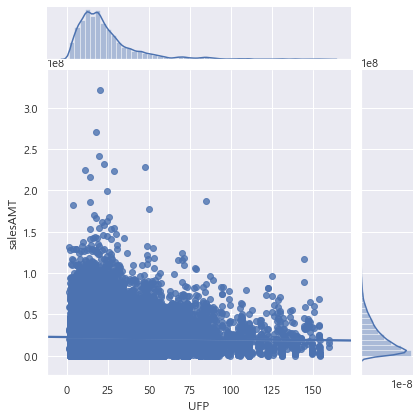

In [47]:
sns.jointplot(data=data, x="UFP", y="salesAMT", kind = "reg")
plt.show()

### 미세먼지, 초미세먼지

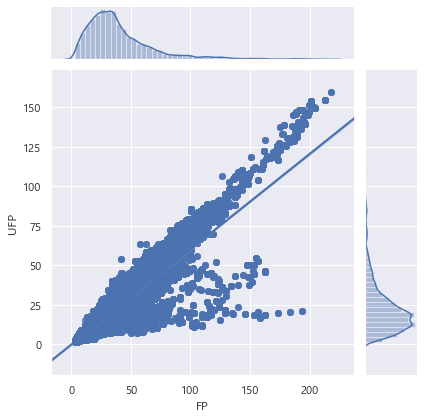

In [65]:
sns.jointplot(data=data, x="FP", y="UFP", kind = "reg")
plt.show()

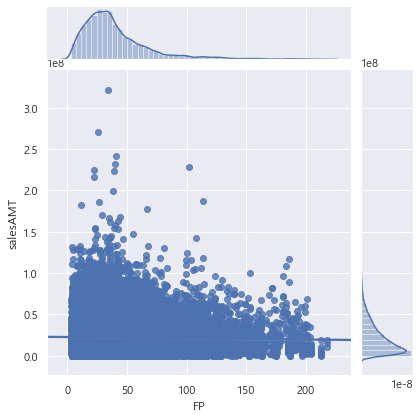

In [66]:
sns.jointplot(data=data, x="FP", y="salesAMT", kind = "reg")
plt.show()

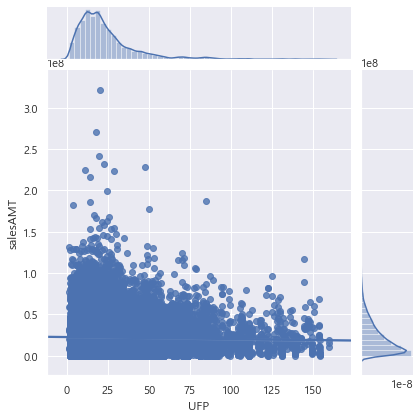

In [67]:
sns.jointplot(data=data, x="UFP", y="salesAMT", kind = "reg")
plt.show()

### 방송별 분석

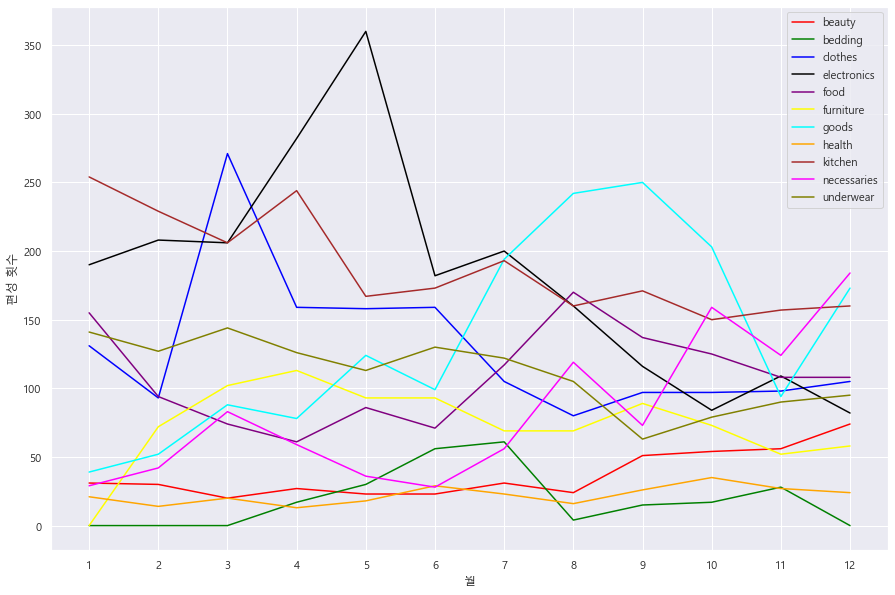

In [68]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(data_monthly_cate_program_pivot["beauty"], color="red")
plt.plot(data_monthly_cate_program_pivot["bedding"], color="green")
plt.plot(data_monthly_cate_program_pivot["clothes"], color="blue")
plt.plot(data_monthly_cate_program_pivot["electronics"], color="black")
plt.plot(data_monthly_cate_program_pivot["food"], color="purple")
plt.plot(data_monthly_cate_program_pivot["furniture"], color="yellow")
plt.plot(data_monthly_cate_program_pivot["goods"], color="cyan")
plt.plot(data_monthly_cate_program_pivot["health"], color="orange")
plt.plot(data_monthly_cate_program_pivot["kitchen"], color="brown")
plt.plot(data_monthly_cate_program_pivot["necessaries"], color="magenta")
plt.plot(data_monthly_cate_program_pivot["underwear"], color="olive")
plt.xlabel("월")
plt.ylabel("편성 횟수")
plt.legend(data_monthly_cate_program_pivot.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

### 불쾌지수

In [69]:
data_daily_salesAMT_pivot = data.pivot_table(index="time_day", columns="time_month", values="salesAMT", aggfunc=np.sum)
data_daily_salesAMT_pivot

time_month,1,2,3,4,5,6,7,8,9,10,11,12
time_day,,,,,,,,,,,,
1,2.816742e+09,1.711128e+09,2.584530e+09,2.076321e+09,2.600986e+09,2.055052e+09,2.287026e+09,2.189200e+09,2.786613e+09,2.221867e+09,1.923319e+09,3.275352e+09
2,2.015183e+09,2.016782e+09,2.385806e+09,2.029068e+09,1.673131e+09,2.520729e+09,2.156301e+09,1.870202e+09,2.193250e+09,2.156722e+09,2.512015e+09,2.343164e+09
3,2.060681e+09,2.030100e+09,2.270346e+09,1.717286e+09,2.109801e+09,2.023903e+09,2.372393e+09,2.113118e+09,2.571808e+09,2.821896e+09,2.362378e+09,2.571322e+09
4,2.098390e+09,1.715077e+09,1.658678e+09,1.772177e+09,1.919188e+09,2.219234e+09,2.193087e+09,2.741501e+09,2.638079e+09,1.788475e+09,2.307454e+09,2.231532e+09
5,2.621592e+09,1.731605e+09,1.930771e+09,1.745651e+09,2.333563e+09,1.811011e+09,2.136432e+09,2.062928e+09,2.605595e+09,2.559786e+09,2.219909e+09,2.359995e+09
6,2.499443e+09,2.371259e+09,2.190692e+09,2.036419e+09,2.478507e+09,3.055809e+09,2.472907e+09,2.485295e+09,2.071091e+09,2.523054e+09,2.579771e+09,2.990382e+09
7,2.056169e+09,2.249039e+09,1.670167e+09,2.478826e+09,1.874979e+09,2.200363e+09,2.708997e+09,2.317847e+09,3.009725e+09,2.391439e+09,2.044975e+09,3.481493e+09
8,2.137711e+09,2.296514e+09,2.047584e+09,1.893188e+09,2.092670e+09,2.471085e+09,1.900791e+09,2.015172e+09,2.712441e+09,2.109382e+09,2.373547e+09,3.153872e+09
9,2.073450e+09,2.512340e+09,1.889103e+09,2.134737e+09,2.175839e+09,2.907154e+09,2.159956e+09,1.896113e+09,2.085382e+09,2.806624e+09,2.176124e+09,2.557428e+09


In [70]:
data_precipitation_pivot_T =  data_precipitation.pivot_table(index="time_day", columns="time_month", values="discomfort_index")
data_precipitation_pivot_T

time_month,1,2,3,4,5,6,7,8,9,10,11,12
time_day,,,,,,,,,,,,
1,32.721250,36.802596,48.360982,47.230710,60.530704,64.277655,71.687484,77.743768,71.361320,70.760799,58.630129,42.287676
2,34.134372,39.685600,50.144672,48.897877,60.900265,66.164969,72.322560,79.610736,71.642496,70.029920,56.836972,39.307480
3,36.572180,38.723343,52.096184,50.009864,62.081875,68.687101,71.996114,80.330140,72.282884,70.224984,58.353234,38.242535
4,36.868105,39.796824,52.244961,51.519440,64.117020,69.159736,73.338216,79.634203,72.130080,70.075340,57.109236,42.794880
5,37.151984,44.291112,49.136608,54.298260,63.537464,70.333860,74.139104,81.416225,72.671580,64.505638,55.026376,36.784736
6,38.056800,45.352201,49.812800,51.800893,58.059905,68.548192,76.534127,80.625776,75.369106,62.893546,53.041240,34.572355
7,37.253016,37.146555,48.203930,55.718994,58.633700,66.751500,73.180589,77.719511,75.240247,58.611840,51.529824,33.516600
8,37.957850,34.952215,47.986166,54.975104,59.488552,68.283075,71.546834,79.927054,74.114657,58.355764,49.431648,35.681659
9,37.034536,36.032200,49.851304,51.202728,60.670022,68.478524,71.398800,80.927380,74.468907,56.912212,51.968470,42.569024


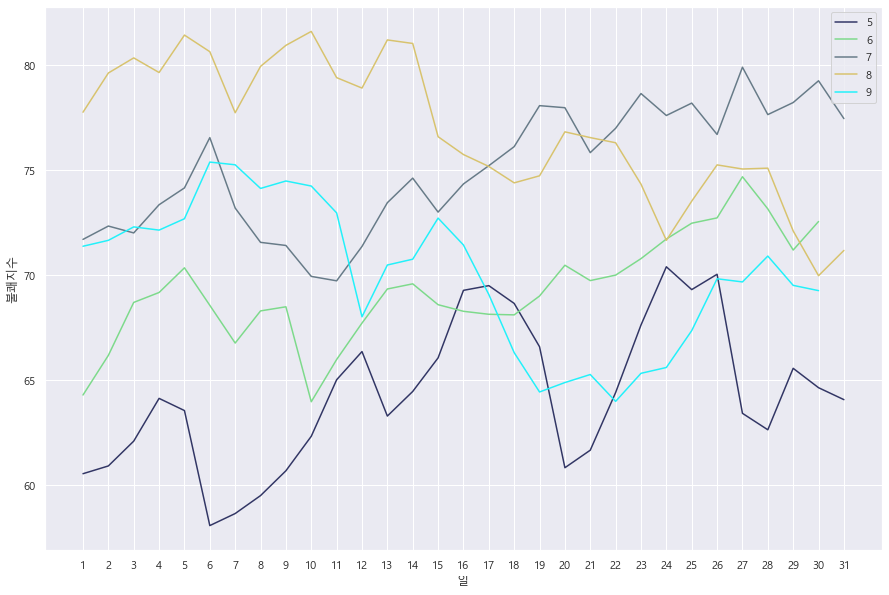

In [71]:
# 월별 불쾌지수 그래프
# x = 일, y=불쾌지수, 선=월
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(1,32), rotation = 0)

for i in range(5, 10):
    plt.plot(data_precipitation_pivot_T.iloc[:,i-1], color=[random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)])

plt.legend([5,6,7,8,9], loc="upper right")
plt.xlabel("일")
plt.ylabel("불쾌지수")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

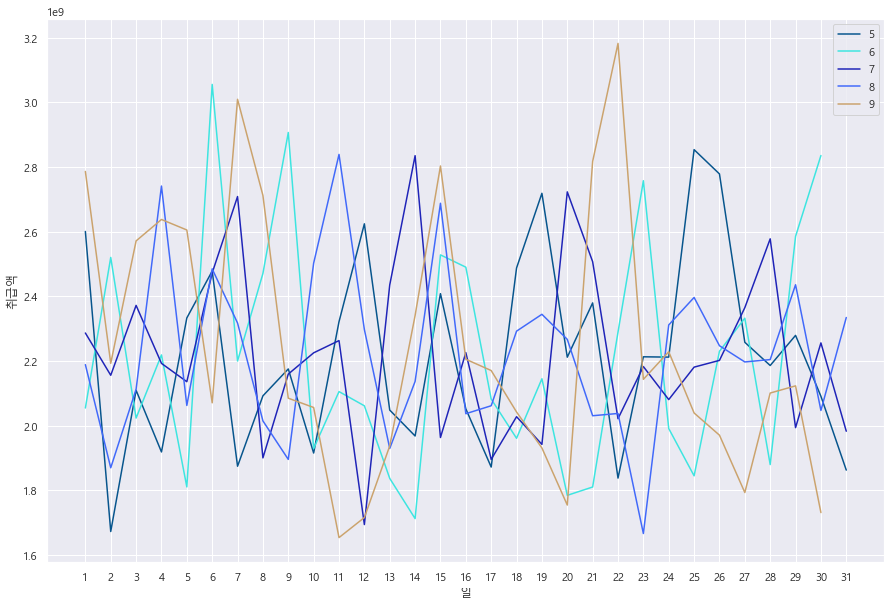

In [72]:
# 월별 판매량 그래프
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(1,32), rotation = 0)

for i in range(5, 10):
    plt.plot(data_daily_salesAMT_pivot.iloc[:,i-1], color=[random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)])

plt.legend([5,6,7,8,9], loc="upper right")
plt.xlabel("일")
plt.ylabel("취급액")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

In [73]:
data_daily_categorical_sales_pivot = data.pivot_table(index=["time_month", "time_day"], columns="category", values="sales", aggfunc=np.sum).fillna(0)
data_daily_categorical_sales_pivot.iloc[121]

category
beauty            0.000000
bedding           0.000000
clothes        2397.416107
electronics     359.471758
food           7259.122582
furniture       118.168892
goods          1916.987248
health          841.129870
kitchen        2469.967220
necessaries     504.002963
underwear      6780.637617
Name: (5, 2), dtype: float64

### 월별 분석

#### 월별 총 취급액

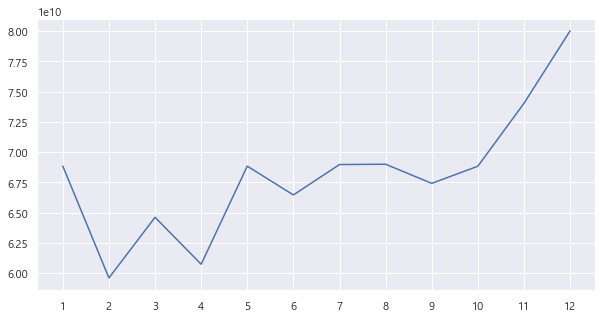

In [74]:
data_monthly_pivot = data.pivot_table(index="time_month", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(13), rotation = 0)
plt.plot(data_monthly_pivot)
plt.show()

#### 월-제품군 별 총 취급액

In [75]:
data_MonthCate_pivot = data.pivot_table(index=["time_month"],columns="category", values="salesAMT", aggfunc=np.sum)
data_MonthCate_pivot = data_MonthCate_pivot.fillna(0)
data_MonthCate_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_month,,,,,,,,,,,
1,3.456610e+09,0.000000e+00,8.508143e+09,7.443582e+09,2.053628e+10,0.000000e+00,1.921087e+09,1.208088e+09,1.261396e+10,2.561073e+09,1.060010e+10
2,2.982287e+09,0.000000e+00,6.353548e+09,9.637182e+09,1.201721e+10,2.865252e+09,3.777191e+09,1.136406e+09,1.119485e+10,3.123247e+09,6.527907e+09
3,1.935054e+09,0.000000e+00,1.121355e+10,9.185087e+09,7.617622e+09,3.029636e+09,5.304263e+09,1.463361e+09,9.366818e+09,5.324272e+09,1.018290e+10
4,2.300892e+09,2.325390e+08,9.552297e+09,1.029206e+10,6.889541e+09,3.149639e+09,3.531384e+09,7.976930e+08,1.238186e+10,2.575729e+09,9.043216e+09
5,2.287170e+09,9.268420e+08,1.125595e+10,1.254701e+10,9.772354e+09,2.793887e+09,6.343167e+09,1.106787e+09,8.772368e+09,1.936612e+09,1.110494e+10
6,2.262426e+09,2.343745e+09,1.075734e+10,6.147901e+09,9.247418e+09,2.777056e+09,4.185127e+09,2.747047e+09,1.040034e+10,1.681650e+09,1.391574e+10
7,3.100676e+09,2.054010e+09,7.997335e+09,7.773842e+09,1.438818e+10,2.411248e+09,6.968579e+09,1.917653e+09,1.099400e+10,2.279325e+09,9.093623e+09
8,2.071920e+09,1.385900e+08,7.519910e+09,7.102425e+09,2.101471e+10,2.576131e+09,5.795389e+09,9.936400e+08,9.461386e+09,3.919849e+09,8.410758e+09
9,4.824076e+09,1.373200e+08,7.032600e+09,5.534816e+09,1.870237e+10,3.026932e+09,8.716391e+09,1.875243e+09,9.867296e+09,4.164485e+09,3.541833e+09


#### 월-제품군 별 취급액 비율

In [76]:
MonthCate_df = get_ratio_df(data_MonthCate_pivot, data_monthly_pivot)
MonthCate_df.index = MonthCate_df.index+1
MonthCate_df

,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
1,0.050206,0.000000,0.123577,0.108115,0.298280,0.000000,0.027903,0.017547,0.183212,0.037198,0.153962
2,0.050026,0.000000,0.106576,0.161657,0.201580,0.048063,0.063360,0.019062,0.187785,0.052390,0.109501
3,0.029944,0.000000,0.173524,0.142134,0.117879,0.046882,0.082081,0.022645,0.144947,0.082390,0.157575
4,0.037877,0.003828,0.157248,0.169425,0.113414,0.051849,0.058133,0.013131,0.203827,0.042401,0.148867
5,0.033221,0.013462,0.163492,0.182245,0.141943,0.040581,0.092134,0.016076,0.127418,0.028129,0.161299
6,0.034039,0.035262,0.161848,0.092497,0.139131,0.041782,0.062967,0.041330,0.156477,0.025301,0.209367
7,0.044951,0.029778,0.115940,0.112700,0.208589,0.034957,0.101025,0.027801,0.159383,0.033044,0.131833
8,0.030026,0.002008,0.108977,0.102927,0.304540,0.037333,0.083985,0.014400,0.137112,0.056806,0.121887
9,0.071549,0.002037,0.104305,0.082090,0.277387,0.044894,0.129278,0.027813,0.146348,0.061766,0.052531
10,0.079699,0.006429,0.094718,0.074700,0.231374,0.042823,0.092808,0.036354,0.117753,0.126597,0.096743


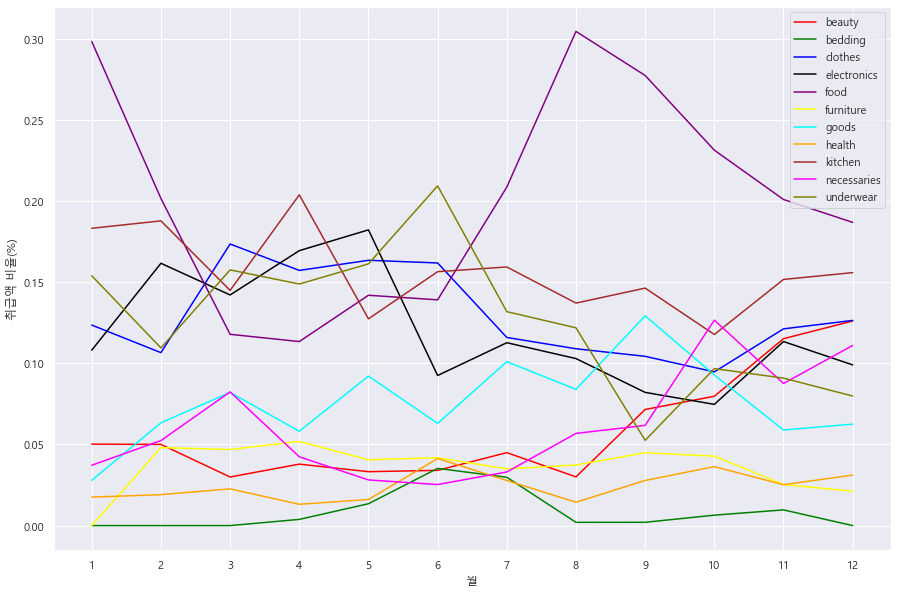

In [77]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(MonthCate_df["beauty"], color="red")
plt.plot(MonthCate_df["bedding"], color="green")
plt.plot(MonthCate_df["clothes"], color="blue")
plt.plot(MonthCate_df["electronics"], color="black")
plt.plot(MonthCate_df["food"], color="purple")
plt.plot(MonthCate_df["furniture"], color="yellow")
plt.plot(MonthCate_df["goods"], color="cyan")
plt.plot(MonthCate_df["health"], color="orange")
plt.plot(MonthCate_df["kitchen"], color="brown")
plt.plot(MonthCate_df["necessaries"], color="magenta")
plt.plot(MonthCate_df["underwear"], color="olive")
plt.xlabel("월")
plt.ylabel("취급액 비율(%)")
plt.legend(MonthCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 월-제품군 별 편성 효율

In [78]:
data_MonthCate_efficiency = (data_MonthCate_pivot / data_monthly_cate_program_pivot).fillna(0)
data_MonthCate_efficiency

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_month,,,,,,,,,,,
1,1.115035e+08,0.000000e+00,6.494766e+07,3.917675e+07,1.324921e+08,0.000000e+00,4.925864e+07,5.752800e+07,4.966127e+07,8.831286e+07,7.517799e+07
2,9.940957e+07,0.000000e+00,6.831772e+07,4.633261e+07,1.278427e+08,3.979517e+07,7.263829e+07,8.117186e+07,4.888579e+07,7.436302e+07,5.140084e+07
3,9.675270e+07,0.000000e+00,4.137843e+07,4.458780e+07,1.029408e+08,2.970231e+07,6.027572e+07,7.316805e+07,4.546999e+07,6.414786e+07,7.071460e+07
4,8.521822e+07,1.367876e+07,6.007734e+07,3.649667e+07,1.129433e+08,2.787291e+07,4.527415e+07,6.136100e+07,5.074535e+07,4.365642e+07,7.177156e+07
5,9.944217e+07,3.089473e+07,7.124018e+07,3.485280e+07,1.136320e+08,3.004180e+07,5.115457e+07,6.148817e+07,5.252915e+07,5.379478e+07,9.827385e+07
6,9.836635e+07,4.185259e+07,6.765623e+07,3.377968e+07,1.302453e+08,2.986082e+07,4.227401e+07,9.472576e+07,6.011756e+07,6.005893e+07,1.070441e+08
7,1.000218e+08,3.367230e+07,7.616510e+07,3.886921e+07,1.229759e+08,3.494562e+07,3.592051e+07,8.337622e+07,5.696373e+07,4.070223e+07,7.453789e+07
8,8.633000e+07,3.464750e+07,9.399888e+07,4.439016e+07,1.236159e+08,3.733523e+07,2.394789e+07,6.210250e+07,5.913366e+07,3.293991e+07,8.010246e+07
9,9.458973e+07,9.154667e+06,7.250103e+07,4.771393e+07,1.365137e+08,3.401047e+07,3.486556e+07,7.212473e+07,5.770349e+07,5.704774e+07,5.621957e+07


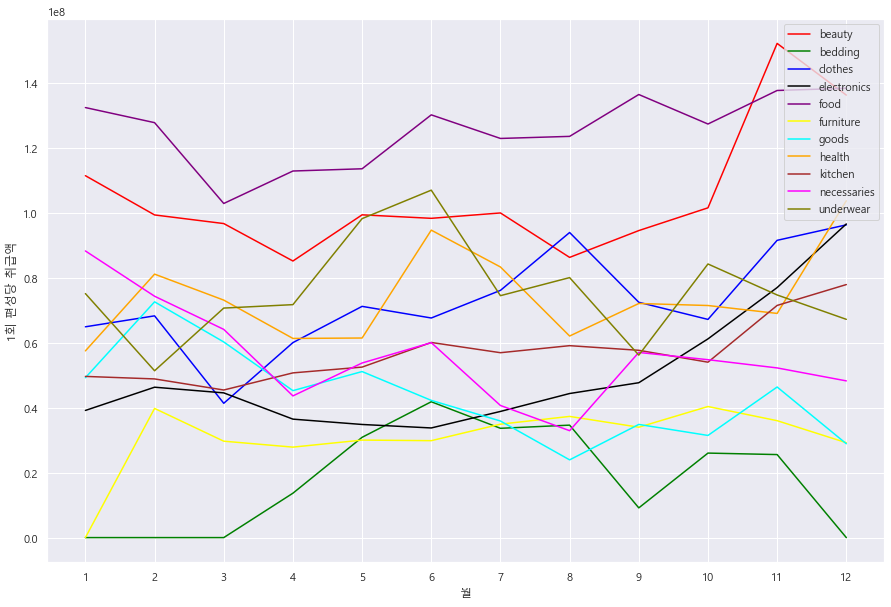

In [79]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(data_MonthCate_efficiency["beauty"], color="red")
plt.plot(data_MonthCate_efficiency["bedding"], color="green")
plt.plot(data_MonthCate_efficiency["clothes"], color="blue")
plt.plot(data_MonthCate_efficiency["electronics"], color="black")
plt.plot(data_MonthCate_efficiency["food"], color="purple")
plt.plot(data_MonthCate_efficiency["furniture"], color="yellow")
plt.plot(data_MonthCate_efficiency["goods"], color="cyan")
plt.plot(data_MonthCate_efficiency["health"], color="orange")
plt.plot(data_MonthCate_efficiency["kitchen"], color="brown")
plt.plot(data_MonthCate_efficiency["necessaries"], color="magenta")
plt.plot(data_MonthCate_efficiency["underwear"], color="olive")
plt.xlabel("월")
plt.ylabel("1회 편성당 취급액")
plt.legend(data_MonthCate_efficiency.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

### 제품 가격별 취급액 산포도

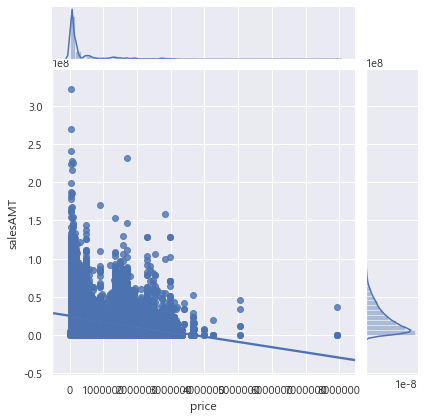

In [80]:
sns.jointplot(data=data, x="price", y="salesAMT", kind = "reg")

### 일별 분석

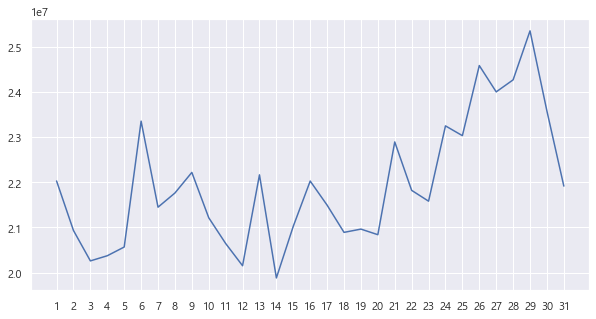

In [81]:
data_dayly_pivot = data.pivot_table(index="time_day", values="salesAMT", aggfunc=np.mean)
plt.xticks(ticks = range(1,32), rotation = 0)
plt.plot(data_dayly_pivot["salesAMT"])
plt.show()

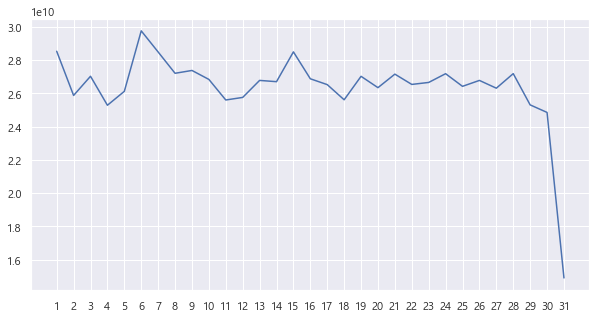

In [82]:
data_dayly_pivot = data.pivot_table(index="time_day", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(1,32), rotation = 0)
plt.plot(data_dayly_pivot["salesAMT"])
plt.show()

In [83]:
data_DayCate_pivot = data.pivot_table(index=["time_day"],columns="category", values="salesAMT", aggfunc=np.mean)
data_DayCate_pivot = data_DayCate_pivot.fillna(0)
data_DayCate_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_day,,,,,,,,,,,
1,4.157162e+07,9.986333e+06,2.442228e+07,1.913810e+07,4.685258e+07,1.063545e+07,1.402416e+07,3.092158e+07,2.109195e+07,1.540719e+07,2.640972e+07
2,3.777733e+07,2.459644e+07,2.319585e+07,1.381646e+07,4.253192e+07,9.755230e+06,1.359727e+07,2.220126e+07,1.675904e+07,2.225801e+07,2.677788e+07
3,3.694636e+07,1.228889e+07,2.472473e+07,1.392148e+07,4.790066e+07,9.115296e+06,1.446768e+07,1.802056e+07,1.617015e+07,1.724409e+07,2.474806e+07
4,3.509312e+07,1.228910e+07,2.043056e+07,1.321205e+07,4.032006e+07,1.023233e+07,1.424214e+07,2.032673e+07,1.826352e+07,1.897125e+07,2.511922e+07
5,3.313627e+07,9.785000e+06,2.423693e+07,1.445994e+07,3.953099e+07,1.334790e+07,1.593236e+07,2.510589e+07,1.496137e+07,1.944139e+07,2.257287e+07
6,4.533221e+07,1.514917e+07,3.118860e+07,1.447829e+07,4.316787e+07,9.624570e+06,1.644772e+07,2.297857e+07,2.229279e+07,2.747040e+07,2.898196e+07
7,4.174789e+07,8.054911e+06,2.912393e+07,1.478673e+07,4.375392e+07,9.682458e+06,1.705578e+07,2.446200e+07,2.088680e+07,1.624199e+07,2.629543e+07
8,3.663080e+07,1.335467e+07,2.503292e+07,1.534700e+07,4.245432e+07,1.084100e+07,1.627562e+07,2.984640e+07,1.689613e+07,1.545153e+07,2.400867e+07
9,3.518441e+07,0.000000e+00,2.346669e+07,1.563066e+07,4.358643e+07,9.022167e+06,1.471493e+07,2.569343e+07,1.983052e+07,2.011846e+07,3.200372e+07


In [84]:
DayCate_df = get_ratio_df(data_DayCate_pivot, data_dayly_pivot)
DayCate_df.index = DayCate_df.index + 1
DayCate_df

,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
1,0.001457,0.000350,0.000856,0.000671,0.001642,0.000373,0.000492,0.001084,0.000739,0.000540,0.000926
2,0.001460,0.000951,0.000897,0.000534,0.001644,0.000377,0.000526,0.000858,0.000648,0.000860,0.001035
3,0.001367,0.000455,0.000915,0.000515,0.001772,0.000337,0.000535,0.000667,0.000598,0.000638,0.000916
4,0.001388,0.000486,0.000808,0.000523,0.001595,0.000405,0.000563,0.000804,0.000722,0.000750,0.000994
5,0.001269,0.000375,0.000928,0.000554,0.001514,0.000511,0.000610,0.000961,0.000573,0.000744,0.000864
6,0.001524,0.000509,0.001048,0.000487,0.001451,0.000323,0.000553,0.000772,0.000749,0.000923,0.000974
7,0.001466,0.000283,0.001022,0.000519,0.001536,0.000340,0.000599,0.000859,0.000733,0.000570,0.000923
8,0.001347,0.000491,0.000920,0.000564,0.001561,0.000399,0.000598,0.001097,0.000621,0.000568,0.000883
9,0.001285,0.000000,0.000857,0.000571,0.001592,0.000330,0.000538,0.000939,0.000724,0.000735,0.001169
10,0.001565,0.000479,0.000982,0.000579,0.001568,0.000470,0.000634,0.000789,0.000610,0.000643,0.000927


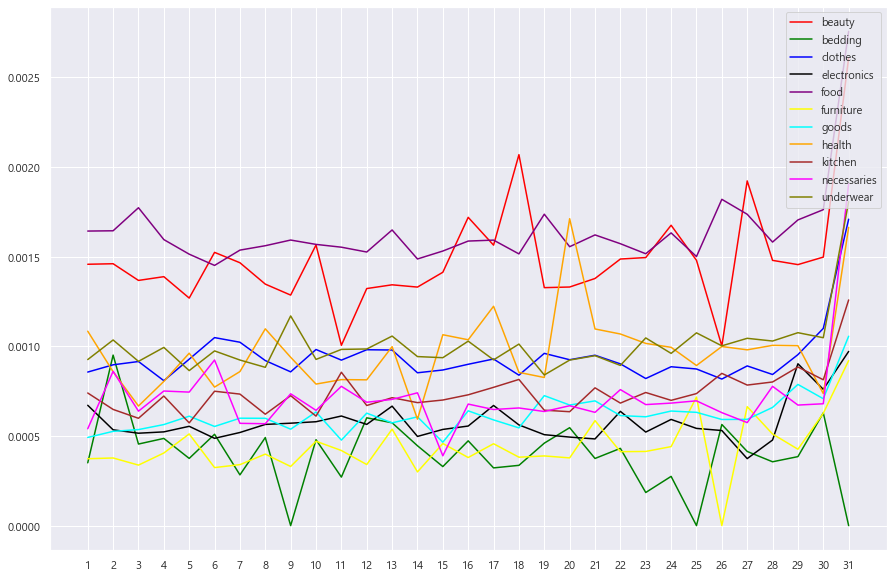

In [85]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(1,32), rotation = 0)

plt.plot(DayCate_df["beauty"], color="red")
plt.plot(DayCate_df["bedding"], color="green")
plt.plot(DayCate_df["clothes"], color="blue")
plt.plot(DayCate_df["electronics"], color="black")
plt.plot(DayCate_df["food"], color="purple")
plt.plot(DayCate_df["furniture"], color="yellow")
plt.plot(DayCate_df["goods"], color="cyan")
plt.plot(DayCate_df["health"], color="orange")
plt.plot(DayCate_df["kitchen"], color="brown")
plt.plot(DayCate_df["necessaries"], color="magenta")
plt.plot(DayCate_df["underwear"], color="olive")

plt.legend(DayCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

### 요일별 분석

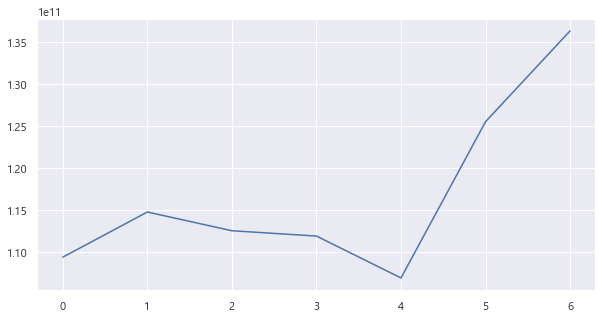

In [86]:
# 요일별 총 취급액
data_DOW_pivot = data.pivot_table(index="day_of_the_week", values="salesAMT", aggfunc=np.sum)
plt.xticks(ticks = range(7), rotation = 0)
plt.plot(data_DOW_pivot["salesAMT"])
plt.show()

In [87]:
data_DOWCate_pivot = data.pivot_table(index=["day_of_the_week"],columns="category", values="salesAMT", aggfunc=np.sum)
data_DOWCate_pivot = data_DOWCate_pivot.fillna(0)
data_DOWCate_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
day_of_the_week,,,,,,,,,,,
0,6.632876e+09,1.207865e+09,1.208269e+10,1.121580e+10,2.472435e+10,4.288623e+09,7.102266e+09,2.203759e+09,1.820053e+10,7.454149e+09,1.429248e+10
1,6.542250e+09,1.111133e+09,1.347375e+10,1.119150e+10,2.543856e+10,4.152825e+09,9.150200e+09,2.879218e+09,1.845282e+10,6.575825e+09,1.580821e+10
2,7.010408e+09,1.265803e+09,1.186034e+10,1.337186e+10,2.332168e+10,4.430722e+09,8.011716e+09,2.824034e+09,2.033965e+10,6.663256e+09,1.344980e+10
3,5.297046e+09,1.025711e+09,1.178658e+10,1.330504e+10,2.467150e+10,3.773124e+09,8.410938e+09,4.437303e+09,1.611882e+10,9.245880e+09,1.384263e+10
4,5.321520e+09,8.337000e+08,1.265779e+10,1.290696e+10,2.248028e+10,4.568805e+09,9.574636e+09,3.331756e+09,1.609905e+10,6.838654e+09,1.231723e+10
5,7.905968e+09,3.458310e+08,2.154831e+10,1.601187e+10,2.425589e+10,3.014505e+09,1.092730e+10,2.205522e+09,1.730334e+10,6.833241e+09,1.517432e+10
6,1.061255e+10,1.201775e+09,2.239413e+10,1.912370e+10,2.104998e+10,4.918137e+09,9.118470e+09,2.222228e+09,2.034817e+10,8.036382e+09,1.731226e+10


In [88]:
DOWCate_df = get_ratio_df(data_DOWCate_pivot, data_DOW_pivot)
DOWCate_df

,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
0,0.060627,0.011040,0.110440,0.102516,0.225988,0.039199,0.064917,0.020143,0.166359,0.068133,0.130638
1,0.057000,0.009681,0.117391,0.097507,0.221636,0.036182,0.079722,0.025085,0.160772,0.057293,0.137731
2,0.062287,0.011247,0.105379,0.118809,0.207213,0.039367,0.071184,0.025092,0.180718,0.059203,0.119501
3,0.047331,0.009165,0.105318,0.118886,0.220449,0.033714,0.075155,0.039649,0.144028,0.082616,0.123689
4,0.049766,0.007797,0.118374,0.120704,0.210233,0.042727,0.089541,0.031158,0.150556,0.063954,0.115189
5,0.062983,0.002755,0.171664,0.127558,0.193234,0.024015,0.087052,0.017570,0.137847,0.054437,0.120886
6,0.077840,0.008815,0.164255,0.140267,0.154396,0.036073,0.066881,0.016299,0.149248,0.058945,0.126981


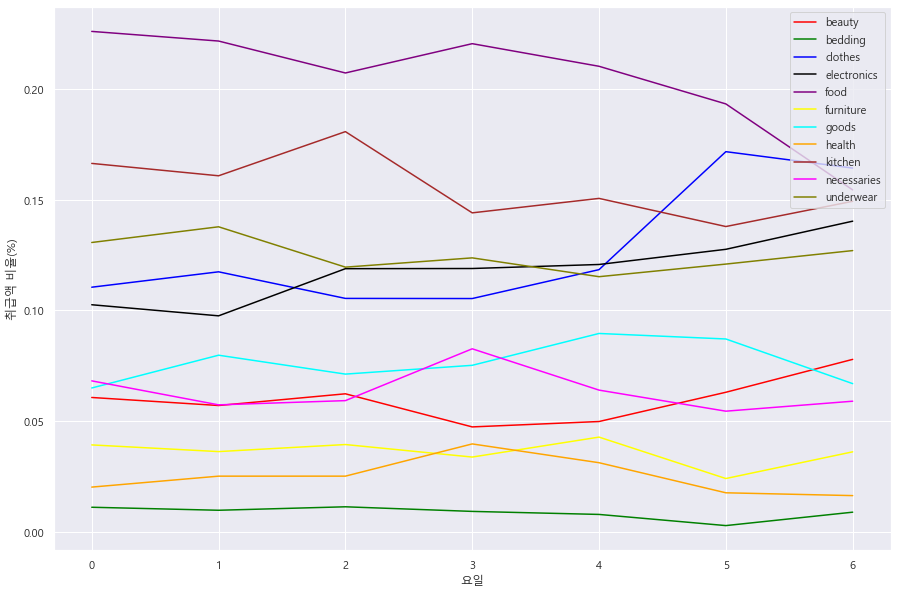

In [89]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(13), rotation = 0)

plt.plot(DOWCate_df["beauty"], color="red")
plt.plot(DOWCate_df["bedding"], color="green")
plt.plot(DOWCate_df["clothes"], color="blue")
plt.plot(DOWCate_df["electronics"], color="black")
plt.plot(DOWCate_df["food"], color="purple")
plt.plot(DOWCate_df["furniture"], color="yellow")
plt.plot(DOWCate_df["goods"], color="cyan")
plt.plot(DOWCate_df["health"], color="orange")
plt.plot(DOWCate_df["kitchen"], color="brown")
plt.plot(DOWCate_df["necessaries"], color="magenta")
plt.plot(DOWCate_df["underwear"], color="olive")
plt.xlabel("요일")
plt.ylabel("취급액 비율(%)")
plt.legend(DOWCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 요일-제품군 별 편성 효율

In [90]:
data_DOWCate_efficiency = (data_DOWCate_pivot / data_DOW_cate_program_pivot).fillna(0)
data_DOWCate_efficiency

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
day_of_the_week,,,,,,,,,,,
0,1.052837e+08,3.264500e+07,5.517212e+07,4.540811e+07,1.223978e+08,3.298941e+07,3.350125e+07,6.121553e+07,5.368889e+07,5.521592e+07,7.040632e+07
1,1.038452e+08,2.057654e+07,6.703358e+07,4.567957e+07,1.246988e+08,3.322260e+07,3.364044e+07,6.855281e+07,4.894647e+07,4.907332e+07,7.456701e+07
2,1.046330e+08,2.943728e+07,6.242283e+07,4.610985e+07,1.233951e+08,3.187570e+07,4.284340e+07,6.887888e+07,5.188685e+07,5.373594e+07,7.390003e+07
3,9.293063e+07,3.205347e+07,7.057831e+07,4.223821e+07,1.239774e+08,3.461582e+07,3.754883e+07,7.784742e+07,5.302242e+07,5.375512e+07,8.001518e+07
4,9.675491e+07,3.970000e+07,6.235365e+07,4.907591e+07,1.208617e+08,3.286910e+07,3.940179e+07,7.932752e+07,5.159952e+07,4.782276e+07,6.919790e+07
5,1.254916e+08,3.842567e+07,7.404919e+07,4.095107e+07,1.355078e+08,3.349450e+07,3.571014e+07,9.589226e+07,7.270313e+07,5.840377e+07,8.524901e+07
6,1.396388e+08,3.755547e+07,7.941182e+07,4.468153e+07,1.431971e+08,3.257044e+07,4.749203e+07,8.888912e+07,6.737806e+07,4.812205e+07,8.283379e+07


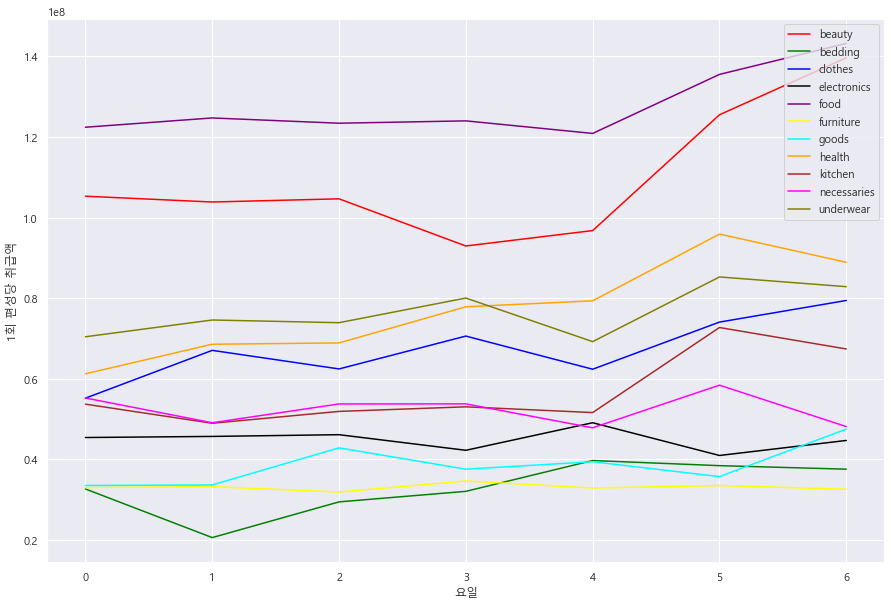

In [91]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(0,7), rotation = 0)

plt.plot(data_DOWCate_efficiency["beauty"], color="red")
plt.plot(data_DOWCate_efficiency["bedding"], color="green")
plt.plot(data_DOWCate_efficiency["clothes"], color="blue")
plt.plot(data_DOWCate_efficiency["electronics"], color="black")
plt.plot(data_DOWCate_efficiency["food"], color="purple")
plt.plot(data_DOWCate_efficiency["furniture"], color="yellow")
plt.plot(data_DOWCate_efficiency["goods"], color="cyan")
plt.plot(data_DOWCate_efficiency["health"], color="orange")
plt.plot(data_DOWCate_efficiency["kitchen"], color="brown")
plt.plot(data_DOWCate_efficiency["necessaries"], color="magenta")
plt.plot(data_DOWCate_efficiency["underwear"], color="olive")
plt.xlabel("요일")
plt.ylabel("1회 편성당 취급액")
plt.legend(data_DOWCate_efficiency.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

### 시간별 분석

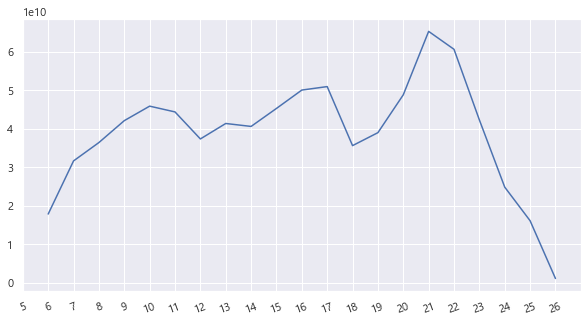

In [98]:
data_grouped_by_broadcast_date_hour = data.pivot_table(index='time_hour', values='salesAMT', aggfunc=np.sum)
plt.xticks(range(0,27), rotation=20)
plt.plot(data_grouped_by_broadcast_date_hour["salesAMT"])
plt.show()

In [99]:
data_HourCate_pivot = data.pivot_table(index=["time_hour"],columns="category", values="salesAMT", aggfunc=np.sum)
data_HourCate_pivot = data_HourCate_pivot.fillna(0)
data_HourCate_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_hour,,,,,,,,,,,
6,1.305497e+09,8.390300e+07,5.341795e+09,0.000000e+00,2.780970e+08,1.613780e+08,1.350567e+09,1.568108e+09,2.203386e+09,2.435215e+09,3.090165e+09
7,2.276557e+09,0.000000e+00,8.754229e+09,1.982600e+08,4.603710e+08,9.112100e+07,4.226417e+09,4.690477e+09,3.768648e+09,2.223372e+09,4.946103e+09
8,2.902313e+09,4.614300e+07,1.058037e+10,2.438790e+08,1.408970e+08,1.668360e+08,5.838278e+09,1.443522e+09,6.011654e+09,3.305786e+09,5.731367e+09
9,3.645472e+09,0.000000e+00,1.220332e+10,7.497490e+08,5.000490e+08,0.000000e+00,6.980311e+09,1.376154e+09,8.455213e+09,2.994438e+09,5.197846e+09
10,2.023499e+09,1.304350e+08,8.762969e+09,2.772517e+09,7.548287e+09,1.119910e+08,7.190507e+09,8.250400e+08,9.683774e+09,1.703778e+09,5.120111e+09
11,1.042427e+09,1.200004e+09,5.931702e+09,1.232250e+09,1.051583e+10,0.000000e+00,6.561360e+09,6.481520e+08,9.051953e+09,1.280114e+09,6.906730e+09
12,3.638020e+09,1.627799e+09,4.218496e+09,1.844797e+09,5.651499e+09,8.796400e+07,3.760009e+09,7.795130e+08,1.041891e+10,2.462929e+09,2.855197e+09
13,3.716337e+09,1.345702e+09,5.694444e+09,1.199700e+09,5.224065e+09,0.000000e+00,6.002389e+09,1.335344e+09,9.392384e+09,1.777980e+09,5.675339e+09
14,3.227549e+09,1.161671e+09,5.884681e+09,1.492956e+09,5.831344e+09,0.000000e+00,4.764341e+09,1.636480e+09,7.356692e+09,2.246453e+09,6.998725e+09


In [100]:
HourCate_df = get_ratio_df(data_HourCate_pivot, data_grouped_by_broadcast_date_hour)
HourCate_df.index = HourCate_df.index + 6
HourCate_df

,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
6,0.073268,0.004709,0.299796,0.000000,0.015608,0.009057,0.075797,0.088006,0.123660,0.136671,0.173428
7,0.071962,0.000000,0.276721,0.006267,0.014552,0.002880,0.133597,0.148266,0.119127,0.070281,0.156346
8,0.079710,0.001267,0.290581,0.006698,0.003870,0.004582,0.160344,0.039645,0.165105,0.090791,0.157407
9,0.086586,0.000000,0.289847,0.017808,0.011877,0.000000,0.165793,0.032686,0.200824,0.071122,0.123457
10,0.044111,0.002843,0.191027,0.060439,0.164548,0.002441,0.156748,0.017985,0.211100,0.037141,0.111615
11,0.023494,0.027045,0.133686,0.027772,0.237000,0.000000,0.147877,0.014608,0.204008,0.028851,0.155660
12,0.097416,0.043588,0.112960,0.049399,0.151332,0.002355,0.100683,0.020873,0.278990,0.065950,0.076454
13,0.089845,0.032533,0.137668,0.029004,0.126296,0.000000,0.145113,0.032283,0.227068,0.042984,0.137206
14,0.079495,0.028612,0.144940,0.036772,0.143626,0.000000,0.117346,0.040307,0.181195,0.055330,0.172379
15,0.055307,0.014299,0.109115,0.017505,0.236725,0.000000,0.073069,0.009831,0.302560,0.025932,0.155657


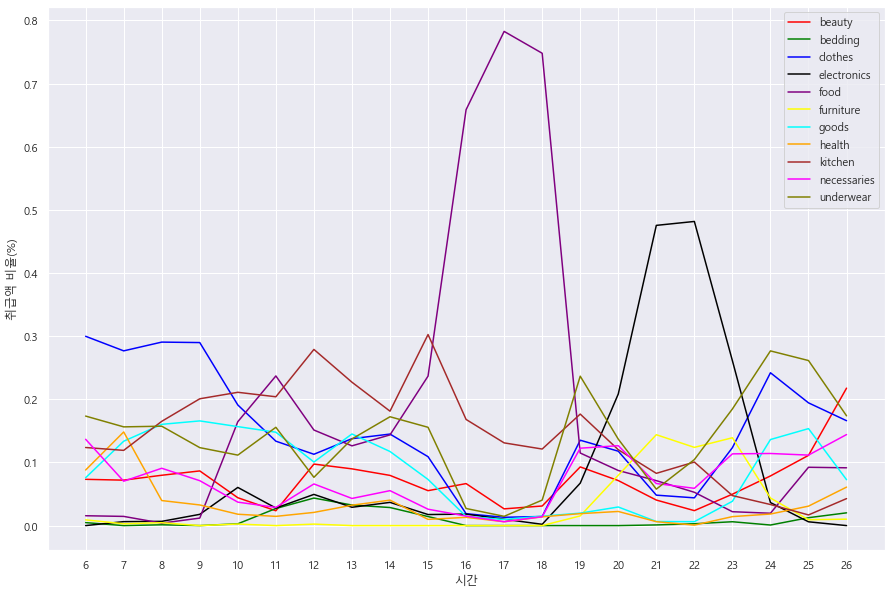

In [101]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(6,27), rotation = 0)

plt.plot(HourCate_df["beauty"], color="red")
plt.plot(HourCate_df["bedding"], color="green")
plt.plot(HourCate_df["clothes"], color="blue")
plt.plot(HourCate_df["electronics"], color="black")
plt.plot(HourCate_df["food"], color="purple")
plt.plot(HourCate_df["furniture"], color="yellow")
plt.plot(HourCate_df["goods"], color="cyan")
plt.plot(HourCate_df["health"], color="orange")
plt.plot(HourCate_df["kitchen"], color="brown")
plt.plot(HourCate_df["necessaries"], color="magenta")
plt.plot(HourCate_df["underwear"], color="olive")
plt.xlabel("시간")
plt.ylabel("취급액 비율(%)")
plt.legend(HourCate_df.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

#### 시간-제품군 별 편성 효율

In [102]:
data_HourCate_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_hour,,,,,,,,,,,
6,1.305497e+09,8.390300e+07,5.341795e+09,0.000000e+00,2.780970e+08,1.613780e+08,1.350567e+09,1.568108e+09,2.203386e+09,2.435215e+09,3.090165e+09
7,2.276557e+09,0.000000e+00,8.754229e+09,1.982600e+08,4.603710e+08,9.112100e+07,4.226417e+09,4.690477e+09,3.768648e+09,2.223372e+09,4.946103e+09
8,2.902313e+09,4.614300e+07,1.058037e+10,2.438790e+08,1.408970e+08,1.668360e+08,5.838278e+09,1.443522e+09,6.011654e+09,3.305786e+09,5.731367e+09
9,3.645472e+09,0.000000e+00,1.220332e+10,7.497490e+08,5.000490e+08,0.000000e+00,6.980311e+09,1.376154e+09,8.455213e+09,2.994438e+09,5.197846e+09
10,2.023499e+09,1.304350e+08,8.762969e+09,2.772517e+09,7.548287e+09,1.119910e+08,7.190507e+09,8.250400e+08,9.683774e+09,1.703778e+09,5.120111e+09
11,1.042427e+09,1.200004e+09,5.931702e+09,1.232250e+09,1.051583e+10,0.000000e+00,6.561360e+09,6.481520e+08,9.051953e+09,1.280114e+09,6.906730e+09
12,3.638020e+09,1.627799e+09,4.218496e+09,1.844797e+09,5.651499e+09,8.796400e+07,3.760009e+09,7.795130e+08,1.041891e+10,2.462929e+09,2.855197e+09
13,3.716337e+09,1.345702e+09,5.694444e+09,1.199700e+09,5.224065e+09,0.000000e+00,6.002389e+09,1.335344e+09,9.392384e+09,1.777980e+09,5.675339e+09
14,3.227549e+09,1.161671e+09,5.884681e+09,1.492956e+09,5.831344e+09,0.000000e+00,4.764341e+09,1.636480e+09,7.356692e+09,2.246453e+09,6.998725e+09


In [103]:
data_hour_cate_program_pivot

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_hour,,,,,,,,,,,
6,32.0,6.0,123.0,0.0,6.0,12.0,45.0,37.0,69.0,76.0,69.0
7,25.0,0.0,121.0,8.0,6.0,10.0,83.0,68.0,64.0,49.0,69.0
8,27.0,3.0,120.0,4.0,1.0,0.0,159.0,16.0,122.0,70.0,70.0
9,30.0,0.0,131.0,24.0,5.0,0.0,167.0,14.0,115.0,42.0,52.0
10,11.0,3.0,92.0,80.0,61.0,6.0,211.0,7.0,193.0,27.0,50.0
11,9.0,32.0,78.0,34.0,87.0,0.0,172.0,7.0,157.0,28.0,63.0
12,36.0,51.0,58.0,44.0,40.0,3.0,102.0,11.0,223.0,35.0,35.0
13,31.0,44.0,89.0,27.0,42.0,0.0,127.0,19.0,157.0,22.0,60.0
14,27.0,29.0,92.0,34.0,54.0,0.0,138.0,13.0,115.0,36.0,79.0


In [104]:
data_HourCate_efficiency = (data_HourCate_pivot / data_hour_cate_program_pivot.replace(0, 1)).fillna(0)
data_HourCate_efficiency

category,beauty,bedding,clothes,electronics,food,furniture,goods,health,kitchen,necessaries,underwear
time_hour,,,,,,,,,,,
6,4.079678e+07,1.398383e+07,4.342923e+07,0.000000e+00,4.634950e+07,1.344817e+07,3.001260e+07,4.238130e+07,3.193313e+07,3.204230e+07,4.478500e+07
7,9.106228e+07,0.000000e+00,7.234900e+07,2.478250e+07,7.672850e+07,9.112100e+06,5.092069e+07,6.897760e+07,5.888512e+07,4.537494e+07,7.168265e+07
8,1.074931e+08,1.538100e+07,8.816974e+07,6.096975e+07,1.408970e+08,1.668360e+08,3.671873e+07,9.022012e+07,4.927585e+07,4.722551e+07,8.187667e+07
9,1.215157e+08,0.000000e+00,9.315508e+07,3.123954e+07,1.000098e+08,0.000000e+00,4.179827e+07,9.829671e+07,7.352359e+07,7.129614e+07,9.995858e+07
10,1.839545e+08,4.347833e+07,9.524966e+07,3.465646e+07,1.237424e+08,1.866517e+07,3.407823e+07,1.178629e+08,5.017499e+07,6.310289e+07,1.024022e+08
11,1.158252e+08,3.750012e+07,7.604746e+07,3.624265e+07,1.208716e+08,0.000000e+00,3.814744e+07,9.259314e+07,5.765575e+07,4.571836e+07,1.096306e+08
12,1.010561e+08,3.191763e+07,7.273269e+07,4.192720e+07,1.412875e+08,2.932133e+07,3.686283e+07,7.086482e+07,4.672158e+07,7.036940e+07,8.157706e+07
13,1.198818e+08,3.058414e+07,6.398252e+07,4.443333e+07,1.243825e+08,0.000000e+00,4.726291e+07,7.028126e+07,5.982410e+07,8.081727e+07,9.458898e+07
14,1.195389e+08,4.005762e+07,6.396392e+07,4.391047e+07,1.079879e+08,0.000000e+00,3.452421e+07,1.258831e+08,6.397123e+07,6.240147e+07,8.859146e+07


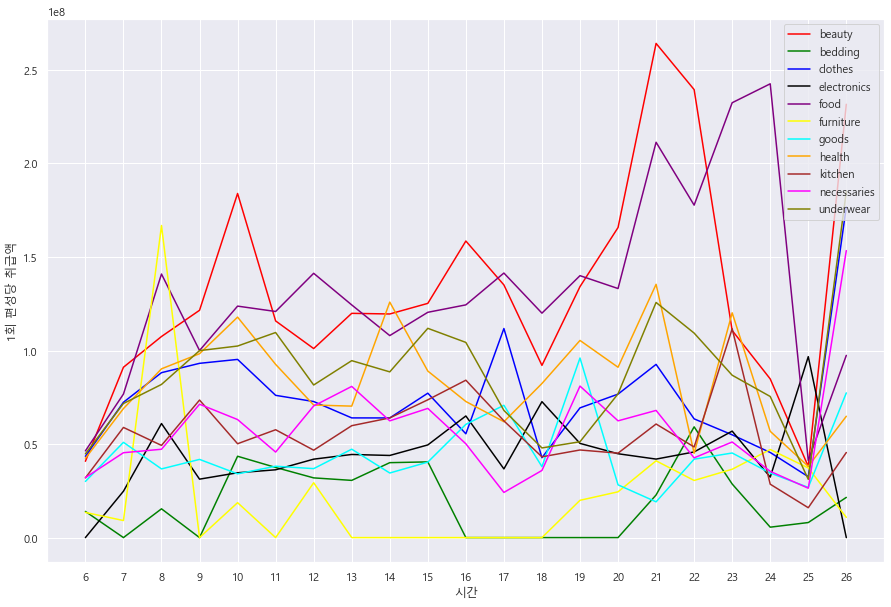

In [105]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.xticks(ticks = range(6,27), rotation = 0)

plt.plot(data_HourCate_efficiency["beauty"], color="red")
plt.plot(data_HourCate_efficiency["bedding"], color="green")
plt.plot(data_HourCate_efficiency["clothes"], color="blue")
plt.plot(data_HourCate_efficiency["electronics"], color="black")
plt.plot(data_HourCate_efficiency["food"], color="purple")
plt.plot(data_HourCate_efficiency["furniture"], color="yellow")
plt.plot(data_HourCate_efficiency["goods"], color="cyan")
plt.plot(data_HourCate_efficiency["health"], color="orange")
plt.plot(data_HourCate_efficiency["kitchen"], color="brown")
plt.plot(data_HourCate_efficiency["necessaries"], color="magenta")
plt.plot(data_HourCate_efficiency["underwear"], color="olive")
plt.xlabel("시간")
plt.ylabel("1회 편성당 취급액")
plt.legend(data_HourCate_efficiency.columns, loc="upper right")
plt.show()
plt.rcParams["figure.figsize"] = (10, 5)

# 가중치(비율) feature화

## 월-상품군 취급액 비율 가중치

In [175]:
for i in range(12):
    for cate in data_accumulated_exposure_time_df["category"].unique():
        data_accumulated_exposure_time_df.loc[
            (data_accumulated_exposure_time_df["category"] == cate) & (data_accumulated_exposure_time_df["time_month"] == i+1),
            "monthCate_weight"] = MonthCate_df.iloc[i][cate]

## 일-상품군 취급액 비율 가중치

In [176]:
for i in range(31):
    for cate in data_accumulated_exposure_time_df["category"].unique():
        data_accumulated_exposure_time_df.loc[
            (data_accumulated_exposure_time_df["category"] == cate) & (data_accumulated_exposure_time_df["time_day"] == i+1),
            "dayCate_weight"] = DayCate_df.iloc[i][cate]

## 요일-상품군 취급액 비율 가중치

In [177]:
for i in range(7):
    for cate in data_accumulated_exposure_time_df["category"].unique():
        data_accumulated_exposure_time_df.loc[
            (data_accumulated_exposure_time_df["category"] == cate) & (data_accumulated_exposure_time_df["day_of_the_week"] == i),
            "DOWCate_weight"] = DOWCate_df.iloc[i][cate]

## 시(hour)-상품군 취급액 비율 가중치

In [178]:
for i in range(6,27):
    for cate in data_accumulated_exposure_time_df["category"].unique():
        data_accumulated_exposure_time_df.loc[
            (data_accumulated_exposure_time_df["category"] == cate) & (data_accumulated_exposure_time_df["time_hour"] == i),
            "hourCate_weight"] = HourCate_df.iloc[i-6][cate]

# MAPE 함수

In [179]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

# Training

In [180]:
data.columns

Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT', 'time_month',
       'time_day', 'time_hour', 'time_min', 'day_of_the_week', 'day_of_year',
       'quater', 'season', 'sales', 'FP', 'UFP', 'discomfort_index',
       'monthCate_weight', 'dayCate_weight', 'DOWCate_weight',
       'hourCateAmount_weight', 'hourCate_weight'],
      dtype='object')

## feature selection

In [227]:
feature_list = [
       'accumulated_exposure_time',
       'mcode', 'product_code', 'price',
#        'time_month', 'time_day', 'time_hour',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6',
       'monthCate_weight', 'DOWCate_weight', 'hourCate_weight',
       # 'FP', 'UFP', "discomfort_index",
#        'category_bedding', 'category_clothes',
#        'category_electronics', 'category_food',
#        'category_furniture', 'category_goods',
#        'category_health', 'category_kitchen',
#        'category_necessaries', 'category_underwear'
]
label = 'salesAMT'

In [228]:
# 상품군 one-hot encoding
data_dummy = pd.get_dummies(data_accumulated_exposure_time_df, columns=['category'], prefix='category', drop_first=True)
data_dummy = pd.get_dummies(data_dummy, columns=["day_of_the_week"], prefix="day_of_week", drop_first=True)

In [229]:
# 이상치 제거
idx_list = data_dummy.loc[(data["price"] > data["salesAMT"]) & (data["salesAMT"] == 50000)].index
data_dummy = data_dummy.drop(idx_list)

In [230]:
train_X = data_dummy[feature_list]
train_y = data_dummy[label]

In [231]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# kfold = KFold(n_splits=5, random_state=47, shuffle=True)
# my_scorer = make_scorer(mape, greater_is_better=False)

## data split

In [232]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=147, shuffle=True)

## Random forest 하이퍼 파라미터 튜닝

In [233]:
rf_model = RandomForestRegressor(n_jobs=-1)
# score = cross_val_score(rf_model, train_X, train_y, scoring=my_scorer, cv=kfold)
# print("교차 검증 점수:\n{}".format(score))

In [234]:
param_dist = {
    "max_depth": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "max_features": sp_randint(1, len(feature_list)+1),
    "min_samples_split": sp_randint(2, 21),
    "min_samples_leaf": sp_randint(1, 21),
    "bootstrap": [True, False],
    "random_state": [147]
}

n_iter_search = 100
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=n_iter_search)

In [235]:
random_search.fit(X_train, y_train)

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ok\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_...


In [236]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.676 (std: 0.011)
Parameters: {'bootstrap': False, 'max_depth': 19, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'random_state': 147}

Model with rank: 2
Mean validation score: 0.666 (std: 0.009)
Parameters: {'bootstrap': False, 'max_depth': 19, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 17, 'random_state': 147}

Model with rank: 3
Mean validation score: 0.662 (std: 0.008)
Parameters: {'bootstrap': False, 'max_depth': 19, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'random_state': 147}



In [239]:
rf_model2 = RandomForestRegressor(
    n_estimators=1000,
    n_jobs=-1,
    bootstrap = False,
    max_depth = 19,
    max_features = 5,
    min_samples_leaf = 2,
    min_samples_split = 4,
    random_state = 147
)

## Use Random Forest model

In [240]:
rf_model2.fit(X_train, y_train)
pred = rf_model2.predict(X_test)

In [241]:
mape(y_test, pred)

65.39844358949779

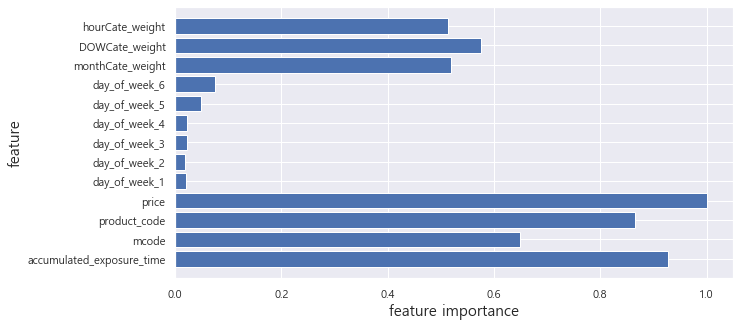

In [242]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

mi = rf_model2.feature_importances_ / rf_model2.feature_importances_.max()
plt.barh(index, mi, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

## Use LGBM

In [243]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    random_state = 147,
    n_estimators = 1000
    )
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [244]:
model_score = mape(y_test, predicted)
model_score

52.94489846685183

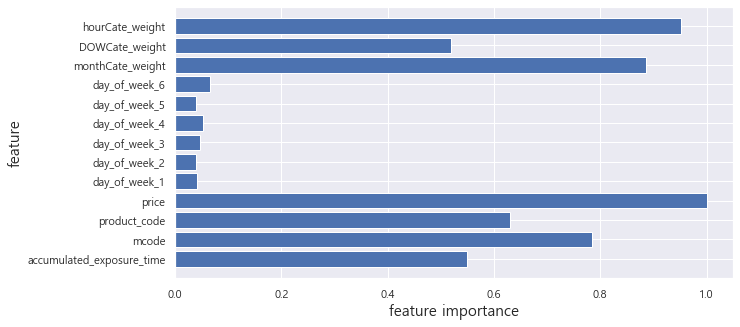

In [245]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

mi = model.feature_importances_ / model.feature_importances_.max()
plt.barh(index, mi, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

In [259]:
iter_num = 10
total_importance = [0] * len(X_train.columns)
total_model_score = 0

for i in range(iter_num):
    random_value = random.randint(1, 10000)
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=random_value, shuffle=True)
    model = lgb.LGBMRegressor(
        random_state = random_value,
        n_estimators = 3000
    )
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    model_score = mape(y_test, predicted)
    print(i, model_score)
    total_model_score = total_model_score + model_score
    total_importance = total_importance + model.feature_importances_

0 53.549437041372116
1 49.803189204147294
2 48.29884440619532
3 48.856940794215085
4 50.28001595906192
5 48.69943550298598
6 52.4731156858235
7 51.56791683160633
8 48.369030100472756
9 55.14464918860313


In [260]:
total_model_score = total_model_score/iter_num
total_model_score

50.704257471448344

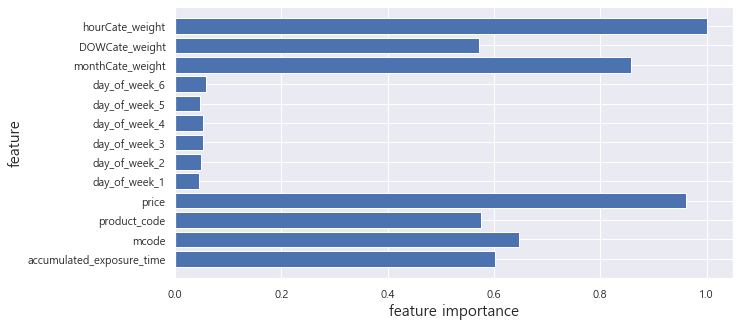

In [261]:
# importance = model.feature_importances_
importance = total_importance/iter_num

n_feature = X_train.shape[1]
index = np.arange(n_feature)

mi = importance / importance.max()

plt.barh(index, mi, align='center')
plt.yticks(index, X_train.columns)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

## 전체 feature간 상관계수

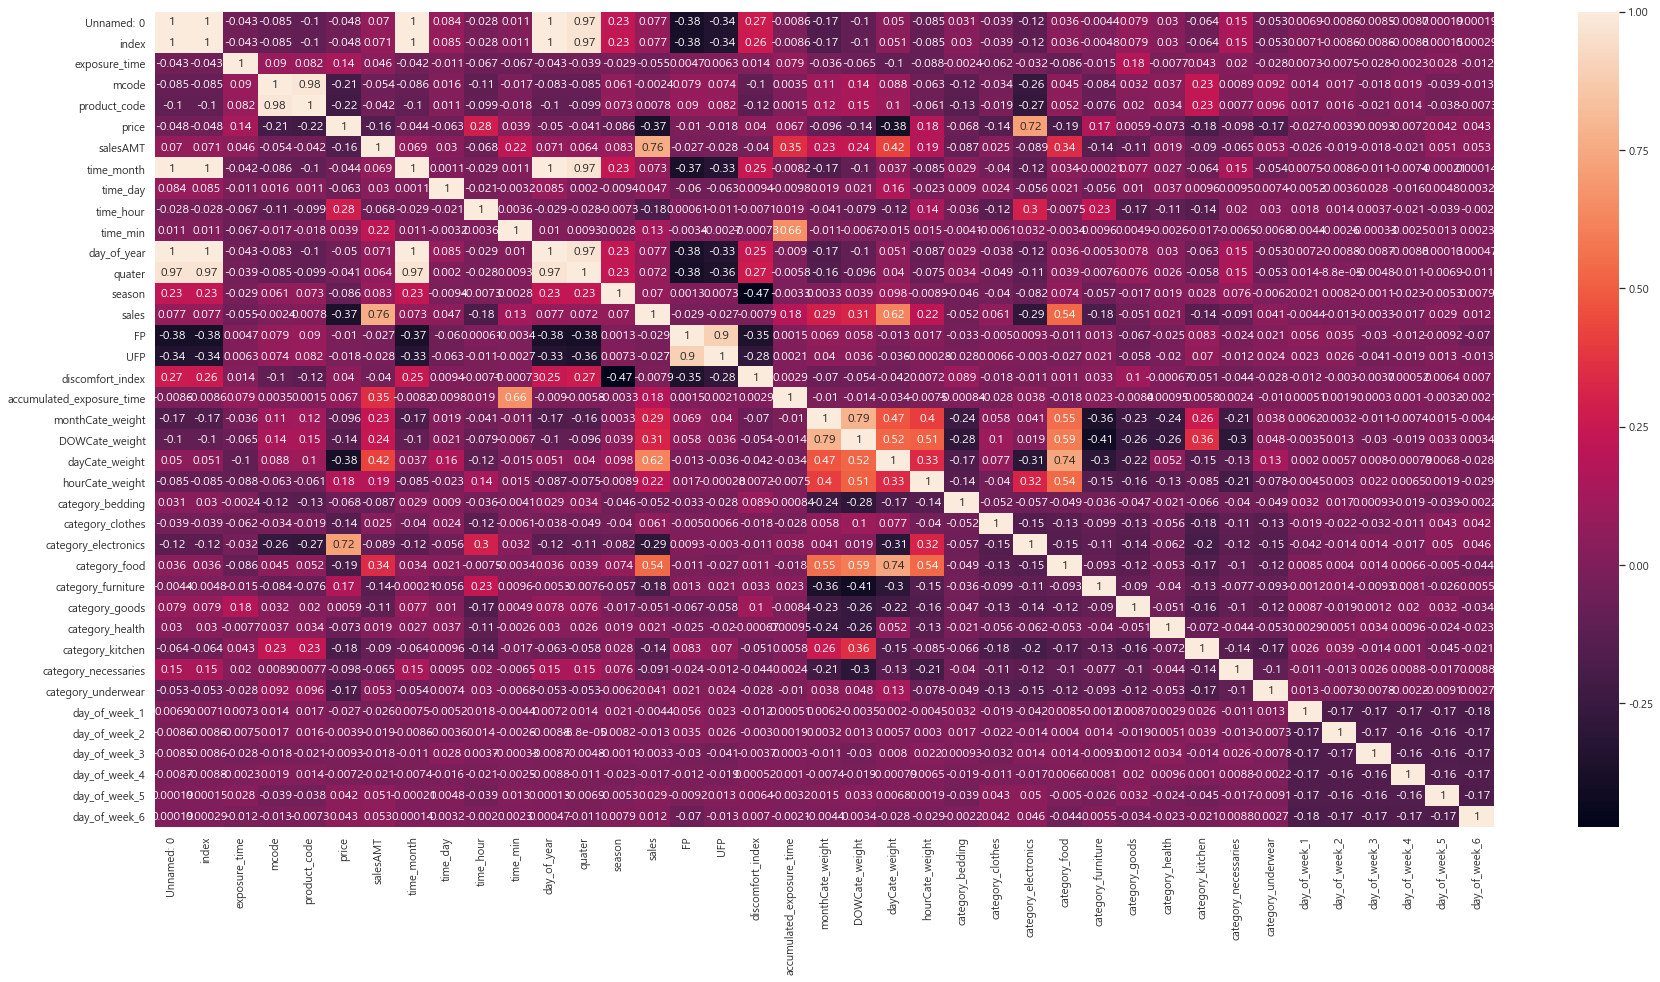

In [262]:
plt.figure(figsize=(30,15))
sns.heatmap(data_dummy.corr(), annot=True)
plt.show()

## 선택 feature간 상관계수

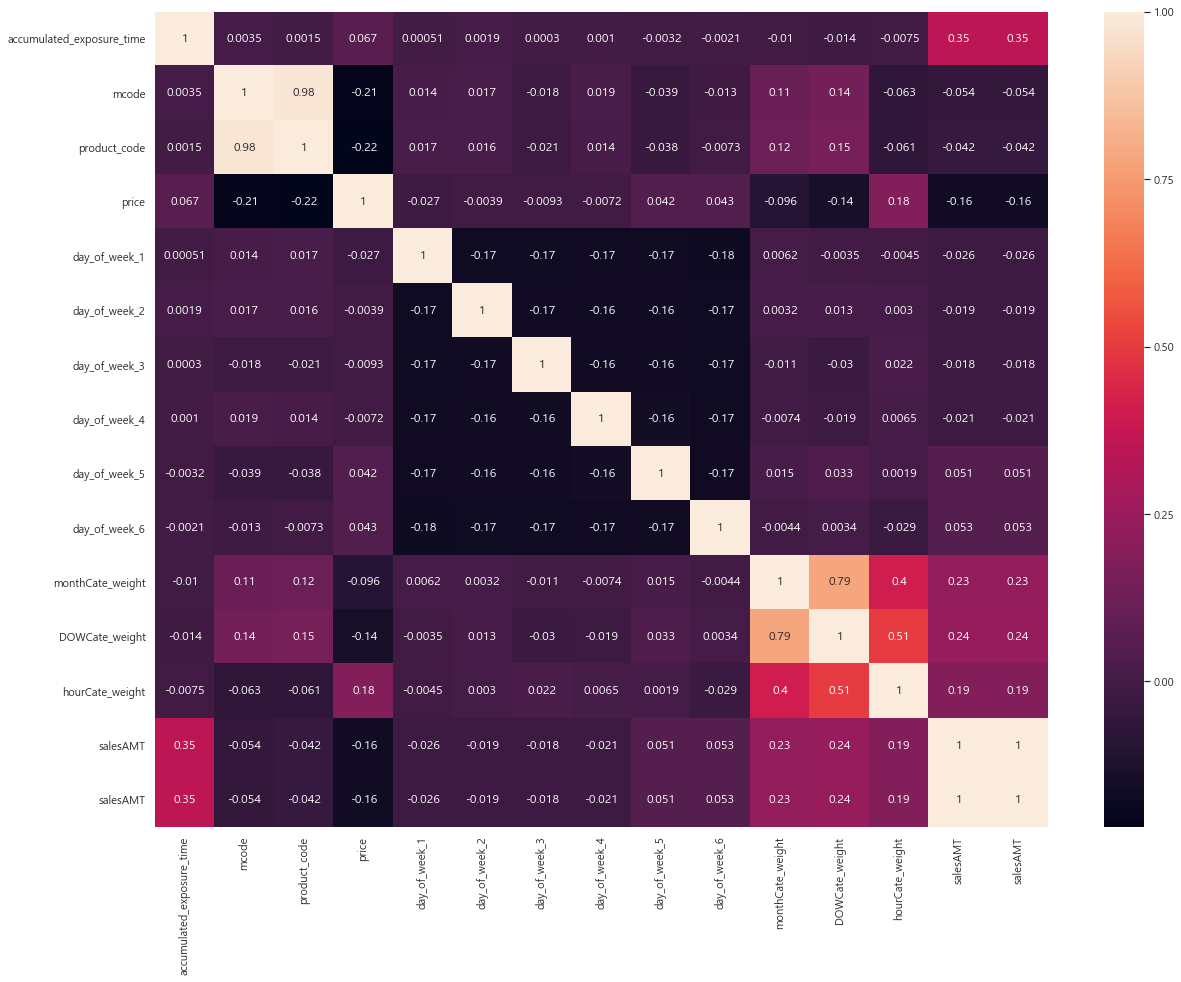

In [263]:
plt.figure(figsize=(20,15))
sns.heatmap(data_dummy[feature_list].corr(), annot=True)
plt.show()